In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process import *

In [2]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except ValueError:
        if type(z) == str:
            z = float(z.split('±')[0])
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

In [3]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval07-18.csv')
# df_eval['redshift'] = df_eval['redshift'].apply(lambda x: float(x.split('±')[0]) if '±' in x else float(x))
# df_eval.to_csv('candidateEval07-18.csv', index=False)
# df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [4]:
for i, row in enumerate(df_eval.itertuples()):
    z = row.redshift
    if z is None or z is np.nan:
        continue
    elif type(z) == str:
        z = float(z.split('±')[0])
    df_eval.at[i, 'redshift'] = z
        

In [5]:
#df_eval.to_csv('candidateEval07-18.csv', index=False)

In [6]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}
## remove empty lightcurves
lc_dict = {key: val for key, val in lc_dict.items() if not val.empty}

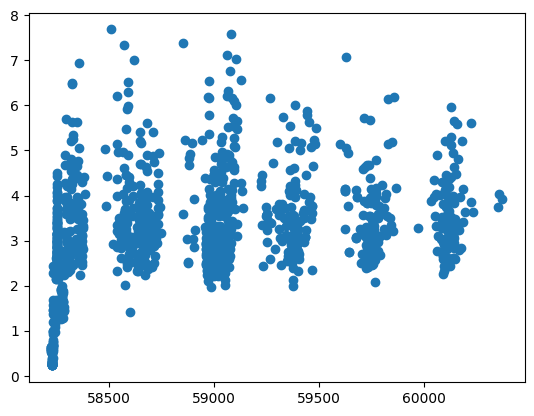

In [7]:
fig, ax = plt.subplots()
ax.scatter(lc_dict['ZTF18aakuewf'].mjd, lc_dict['ZTF18aakuewf'].mag*lc_dict['ZTF18aakuewf'].magerr)

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [8]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_351465/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_351465/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
/tmp/ipykernel_351465/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [9]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]
df_objects = df_objects[df_objects['snr']>5]

In [10]:
# df_objects_norm = pd.DataFrame()
# df_objects_norm['obj_id'] = df_objects['obj_id']
# df_objects_norm['type'] = df_objects['type']
# df_objects_norm['redshift'] = df_objects['redshift']
# df_objects_norm['mjd'] = df_objects['mjd']
# df_objects_norm['mag'] = df_objects['mag']
# df_objects_norm['magerr'] = df_objects['magerr']
# df_objects_norm['filter'] = df_objects['filter']
# df_objects_norm['mjd_0'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
# df_objects_norm['t'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))
# df_objects_norm['absmag'] = absmag(df_objects['mag'], df_objects['redshift'])
# display(df_objects_norm)
# df_objects_norm.to_csv('gp_objects_original_observations.csv', index=False)

In [11]:
df_objects[df_objects['magerr'] < 0]

Empty DataFrame
Columns: [obj_id, type, redshift, mjd, mag, magerr, filter, snr]
Index: []

In [12]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy


In [13]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [14]:
norm_df

obj_id       mjd        flux  flux_error filter type  redshift  \
0     ZTF18aakuewf  0.000000   94.536566    2.762427   ztfr  Ibn    0.0636   
1     ZTF18aakuewf  0.018090  102.621835    2.780158   ztfr  Ibn    0.0636   
2     ZTF18aakuewf  0.038414   97.921932    3.020715   ztfr  Ibn    0.0636   
3     ZTF18aakuewf  0.073924  104.087781    3.031263   ztfr  Ibn    0.0636   
4     ZTF18aakuewf  0.074861  104.761025    3.220689   ztfr  Ibn    0.0636   
...            ...       ...         ...         ...    ...  ...       ...   
5864  ZTF24aascytf  3.190382   26.859287    3.875425   ztfg   II    0.0380   
5865  ZTF24aascytf  5.136296   25.594688    4.422032   ztfr   II    0.0380   
5866  ZTF24aascytf  9.123403   35.998116    6.552586   ztfr   II    0.0380   
5867  ZTF24aascytf  9.123403   35.998749    6.552715   ztfr   II    0.0380   
5868  ZTF24aascytf  9.123403   36.231281    4.404822   ztfr   II    0.0380   

             mjd_0  
0     58226.340532  
1     58226.340532  
2     58226.340532  
3     58226.340532  
4     58226.340532  
...            ...  
5864  60476.217836  
5865  60476.217836  
5866  60476.217836  
5867  60476.217836  
5868  60476.217836  

[5869 rows x 8 columns]

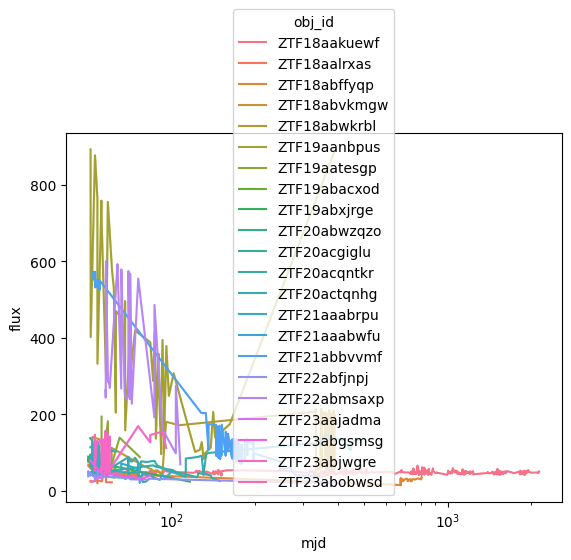

In [15]:
fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['mjd']>50], x='mjd', y='flux', hue='obj_id', ax=ax)
ax.set_xscale('log')

/tmp/ipykernel_351465/4024913305.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)


<Axes: xlabel='mjd', ylabel='flux'>

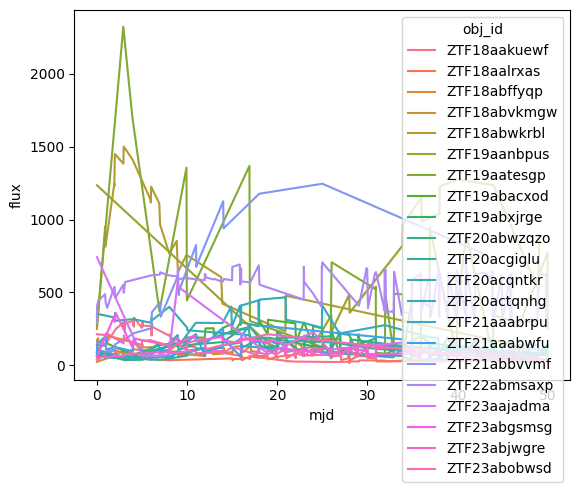

In [16]:
long_objects = norm_df[norm_df.groupby('obj_id')['mjd'].transform('max') > 50]['obj_id'].unique()

fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)

In [17]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [18]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [19]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Cataclysmic                9
FBOT                       2
GRB                        1
II                         6
IIP                        1
IIb                       14
Ia                         3
Ib                         3
Ib/c;Ib-pec                1
Ibn                        2
Novae                      3
Novae;Classical Nova       4
Tidal Disruption Event     1
U Gem                      1
afterglow                  2
afterglow; Ic-BL           1
long GRB                   4
Name: obj_id, dtype: int64
type
Cataclysmic         1
II                  2
IIb                 6
Ia                  2
Ibn                 1
Ic-BL               1
Novae               1
afterglow; Ic-BL    1
Name: obj_id, dtype: int64


In [20]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
} 
## Note for future reference: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Palomar/ZTF.g

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        mjd_0 = obj_df['mjd_0'].values[0]
        redshift = obj_df['redshift'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id
        obj_gps['mjd_0'] = mjd_0
        obj_gps['redshift'] = redshift

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [21]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [22]:
# test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
# train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df[norm_df['mjd']<50], kernel=kernel, save=False, name='total', number_gp=1000)

100%|██████████| 73/73 [00:06<00:00, 11.45it/s]


In [23]:
total_results[total_results['obj_id'] == 'ZTF18aakuewf']


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
0     0.000000  142.373588   98.668109        30.843697         1.246373  Ibn   
1     0.049981  145.014457  101.582057        30.013242         1.080243  Ibn   
2     0.099961  147.656847  104.490322        29.187955         1.080575  Ibn   
3     0.149942  150.300692  107.379974        28.367979         1.219787  Ibn   
4     0.199923  152.945927  110.245034        27.553467         1.433721  Ibn   
..         ...         ...         ...              ...              ...  ...   
995  49.730749   44.116811   38.502774         2.853358       271.797230  Ibn   
996  49.780729   44.140850   38.514448         2.860181       271.986519  Ibn   
997  49.830710   44.165648   38.526084         2.898958       272.176304  Ibn   
998  49.880691   44.190837   38.537680         2.981548       272.366603  Ibn   
999  49.930671   44.216049   38.549235         3.118756       272.557435  Ibn   

           obj_id         mjd_0  redshift  flux_ztfi  flux_error_ztfi  
0    ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
1    ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
2    ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
3    ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
4    ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
..            ...           ...       ...        ...              ...  
995  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
996  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
997  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
998  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
999  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  

[1000 rows x 11 columns]

In [24]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'{obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [25]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      0.000000  142.373588   98.668109        30.843697         1.246373   
1      0.049981  145.014457  101.582057        30.013242         1.080243   
2      0.099961  147.656847  104.490322        29.187955         1.080575   
3      0.149942  150.300692  107.379974        28.367979         1.219787   
4      0.199923  152.945927  110.245034        27.553467         1.433721   
...         ...         ...         ...              ...              ...   
71996  9.086873   33.104947   36.051876        20.273348         3.441576   
71997  9.096005   33.093513   36.039692        20.264562         3.332267   
71998  9.105138   33.081261   36.026243        20.258811         3.251571   
71999  9.114270   33.068191   36.011512        20.256105         3.202154   
72000  9.123403   33.054302   35.995481        20.256452         3.185979   

      type        obj_id         mjd_0  redshift  flux_ztfi  flux_error_ztfi  
0      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
1      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
2      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
3      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
4      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
...    ...           ...           ...       ...        ...              ...  
71996   II  ZTF24aascytf  60476.217836    0.0380  33.927364        19.254350  
71997   II  ZTF24aascytf  60476.217836    0.0380  33.912465        19.244562  
71998   II  ZTF24aascytf  60476.217836    0.0380  33.896745        19.238097  
71999   II  ZTF24aascytf  60476.217836    0.0380  33.880203        19.234967  
72000   II  ZTF24aascytf  60476.217836    0.0380  33.862840        19.235181  

[72001 rows x 11 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


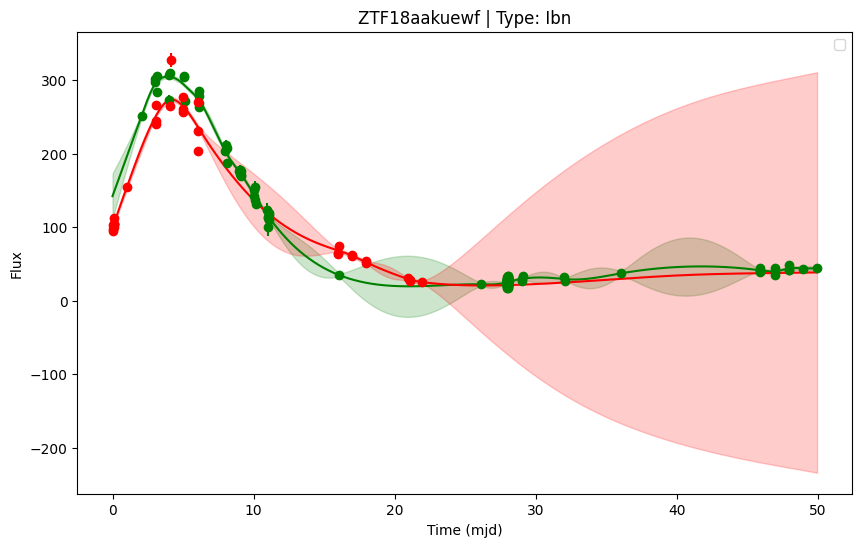

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


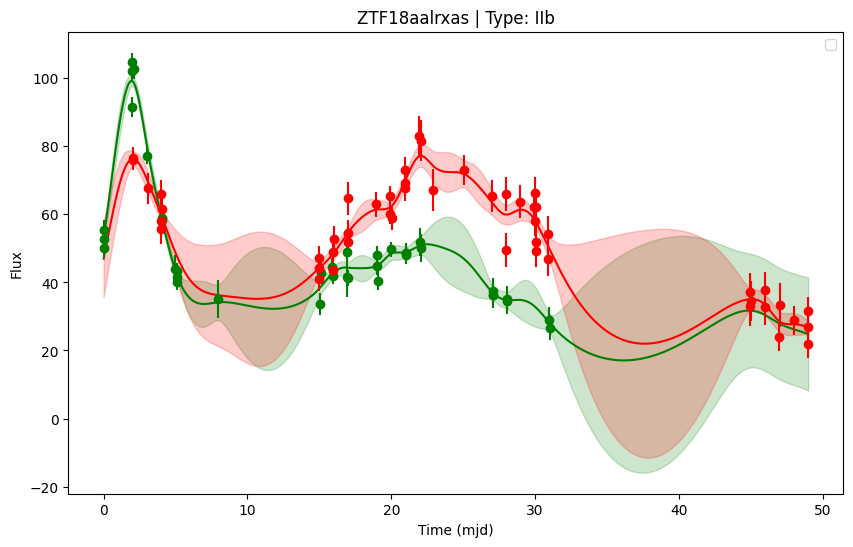

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


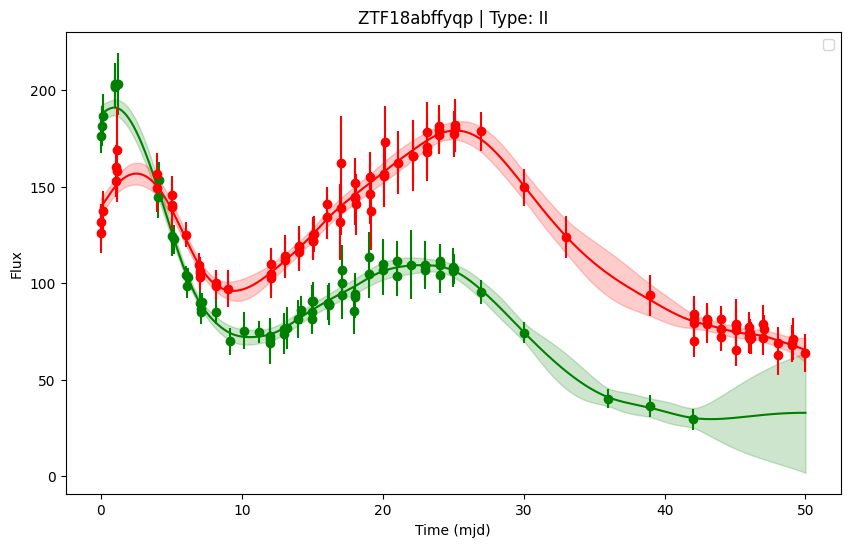

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


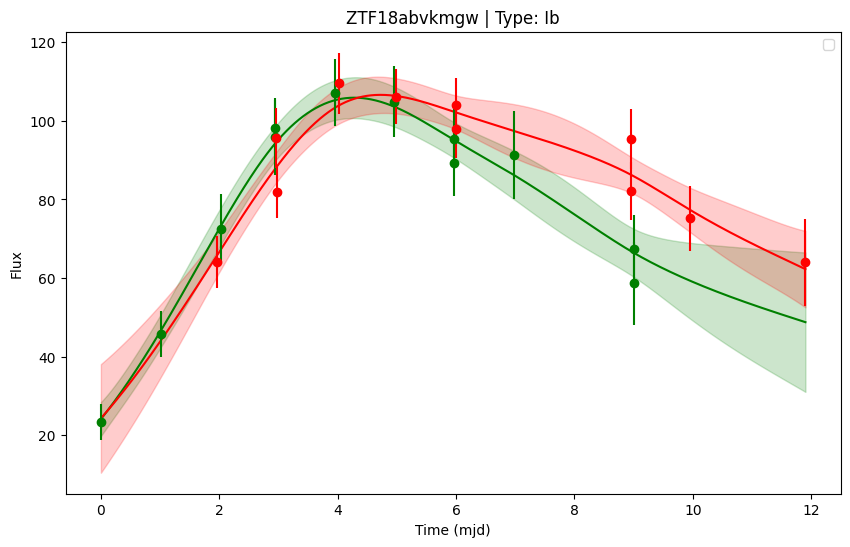

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


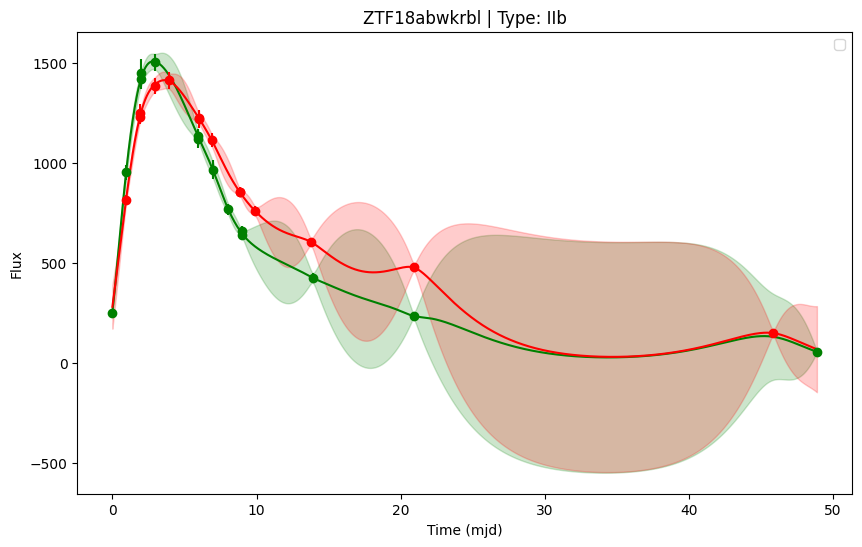

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


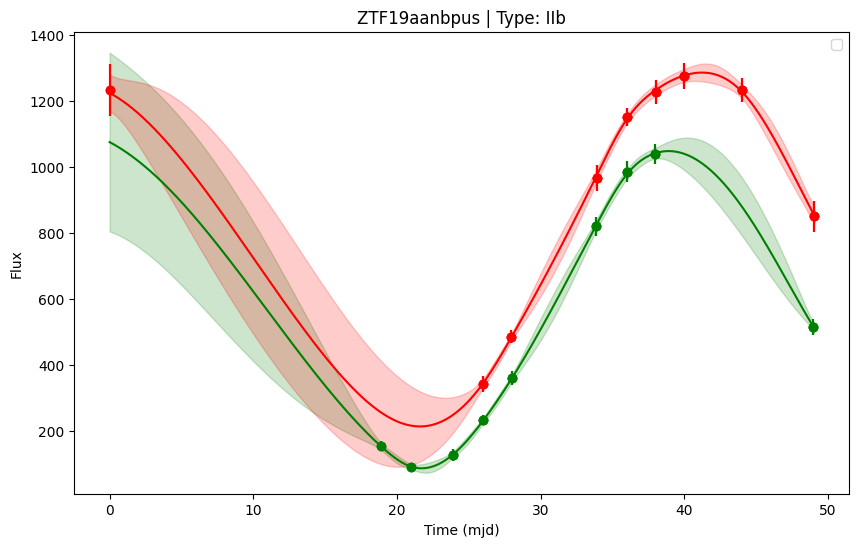

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


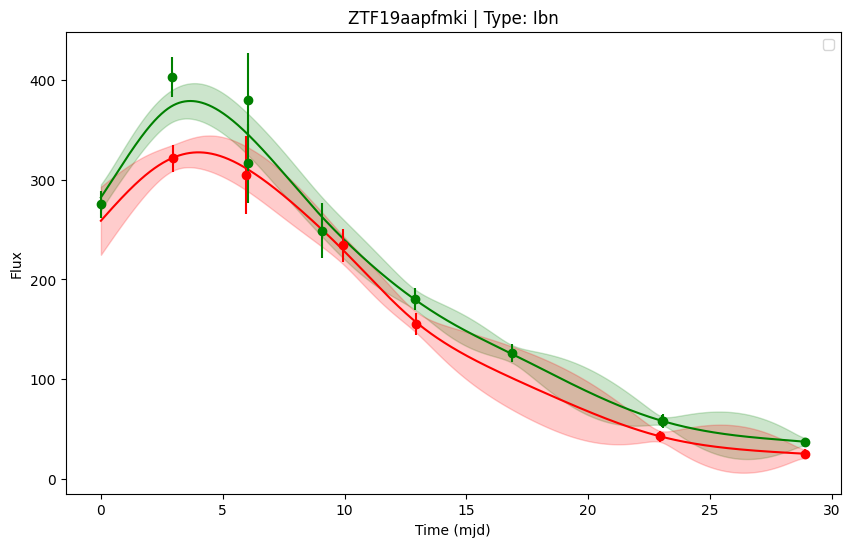

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


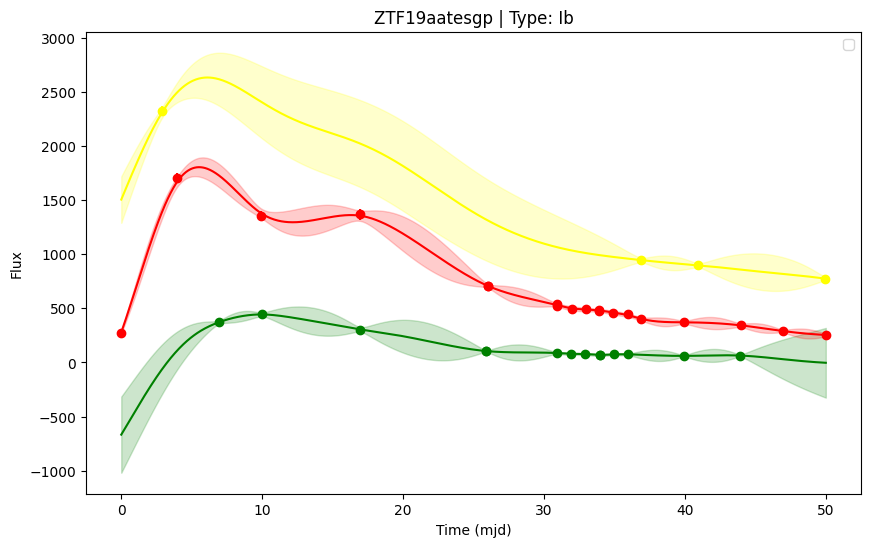

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


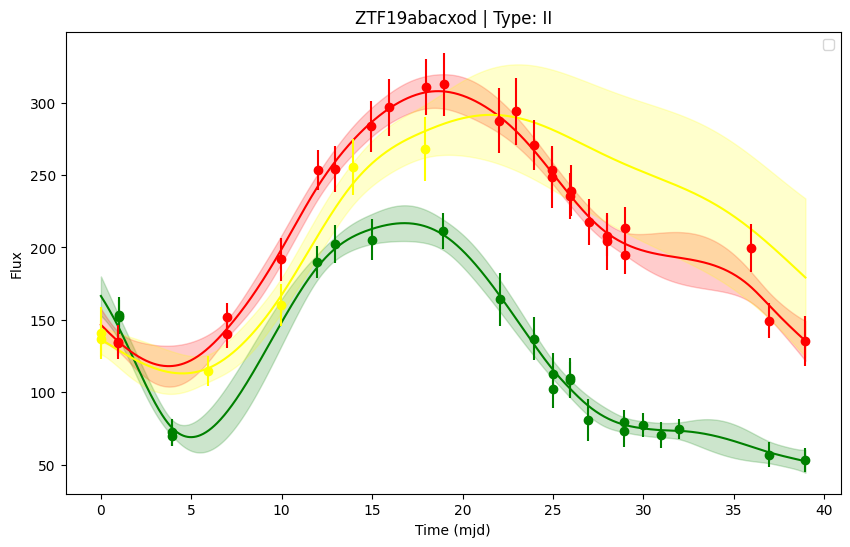

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


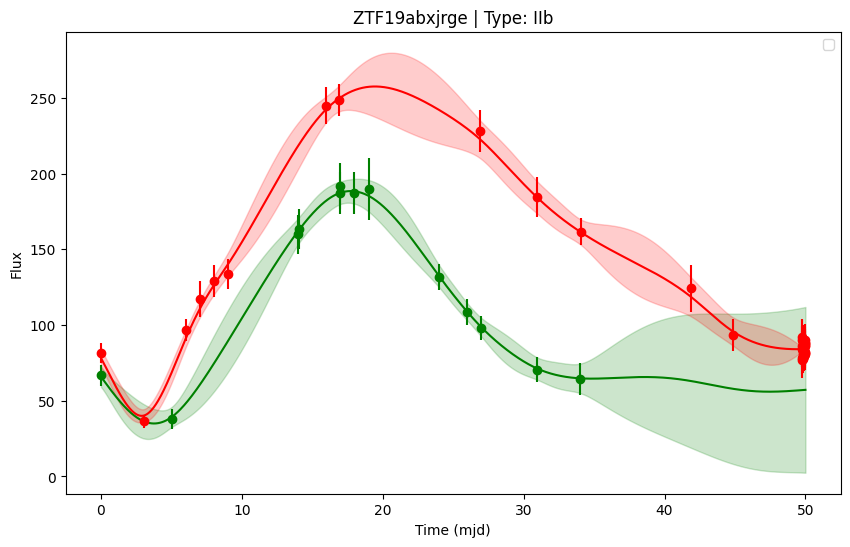

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


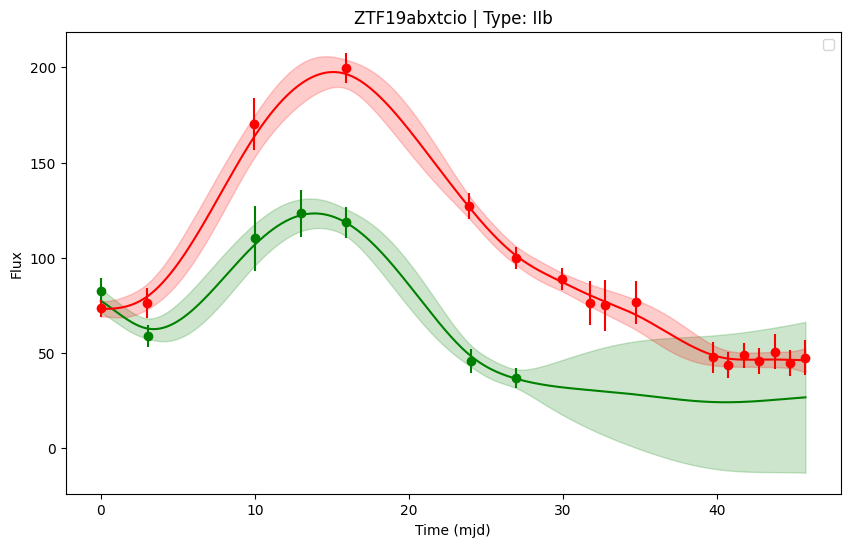

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


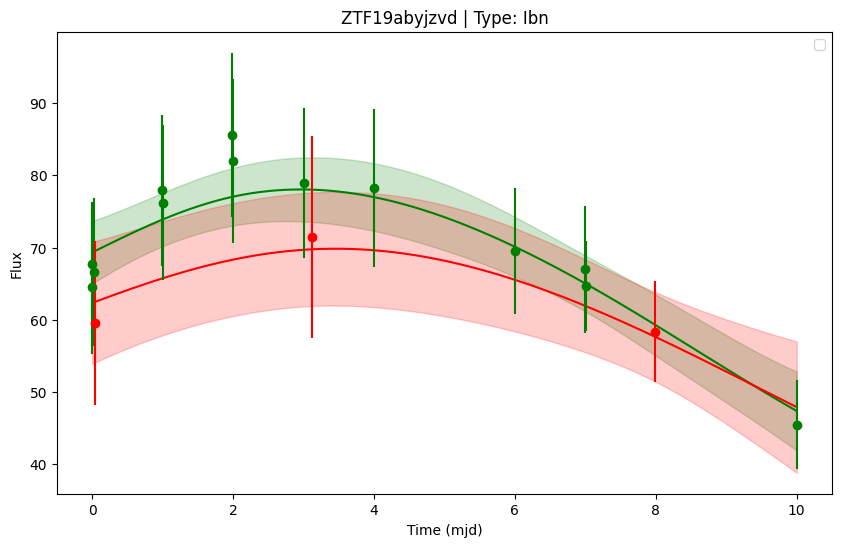

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


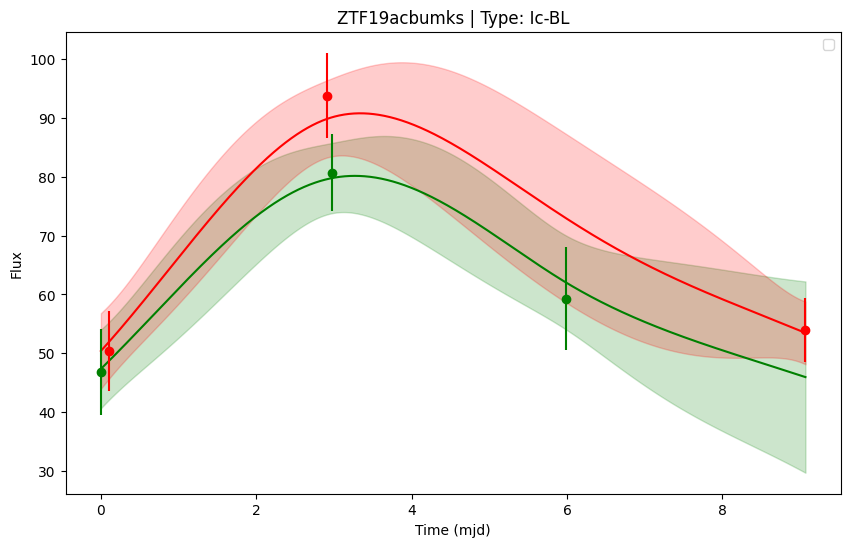

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


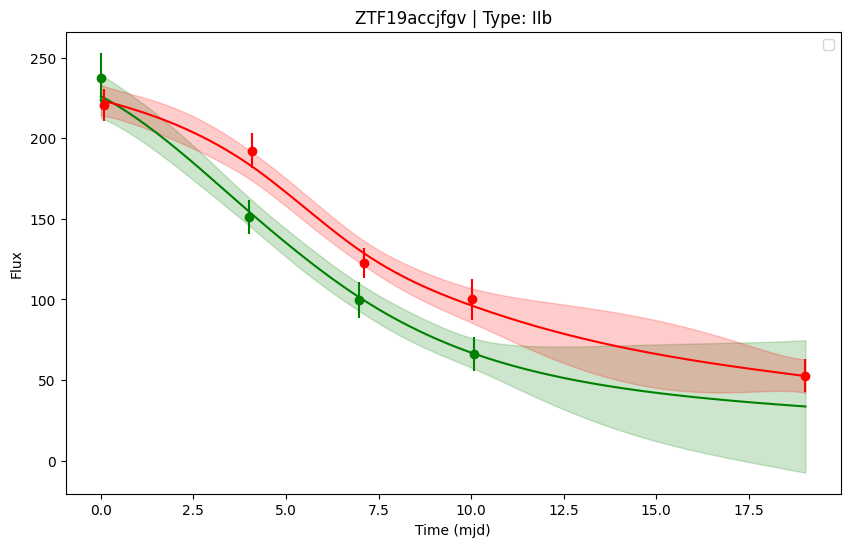

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


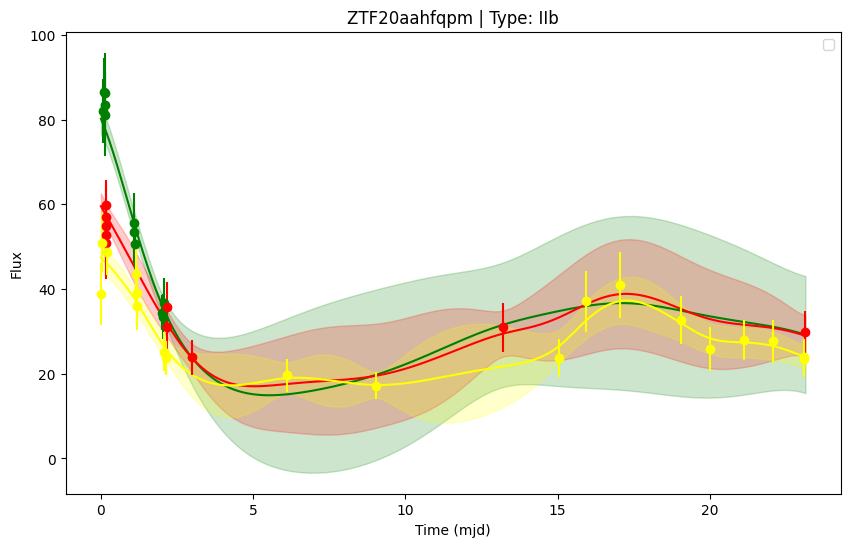

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


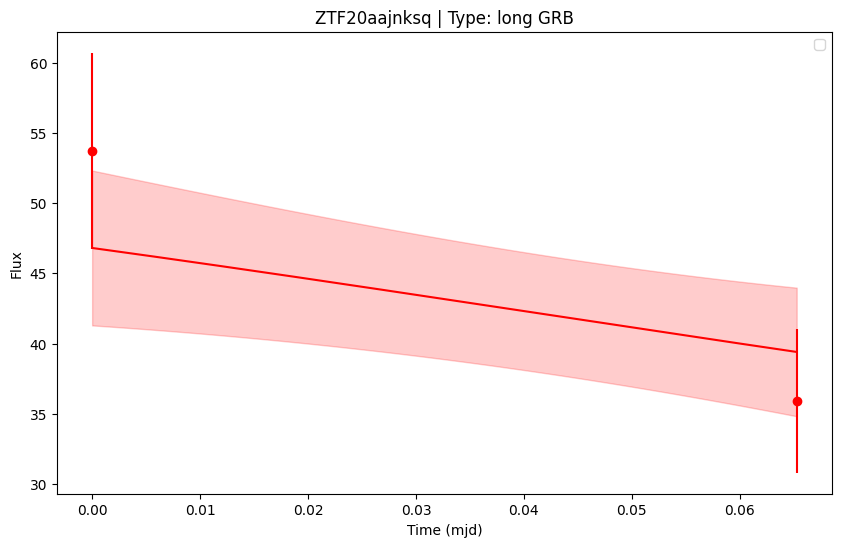

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


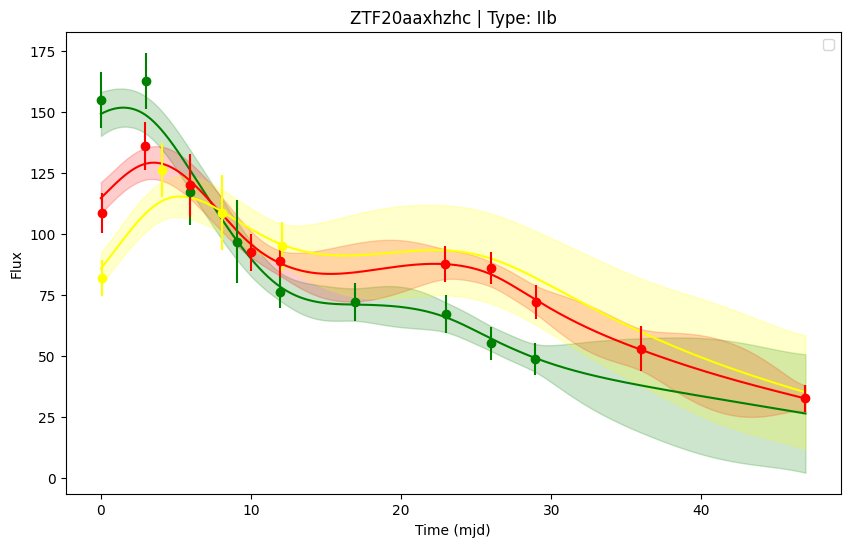

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


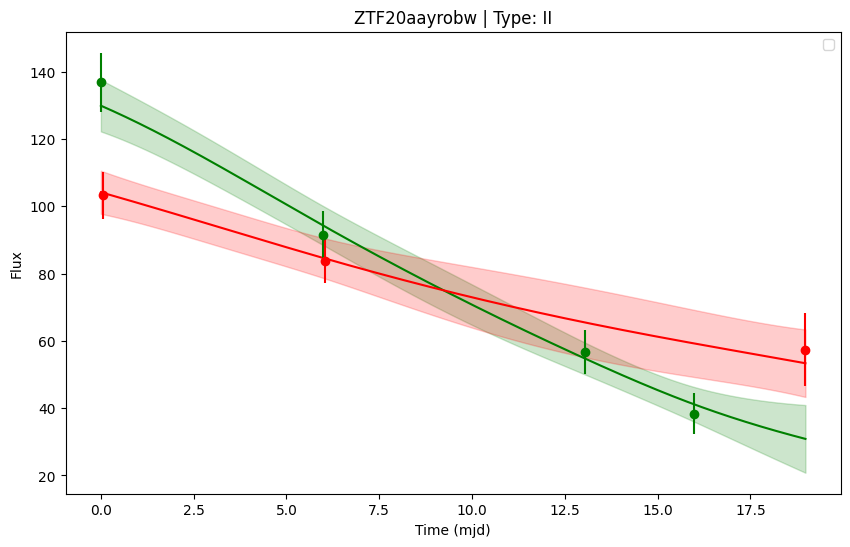

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


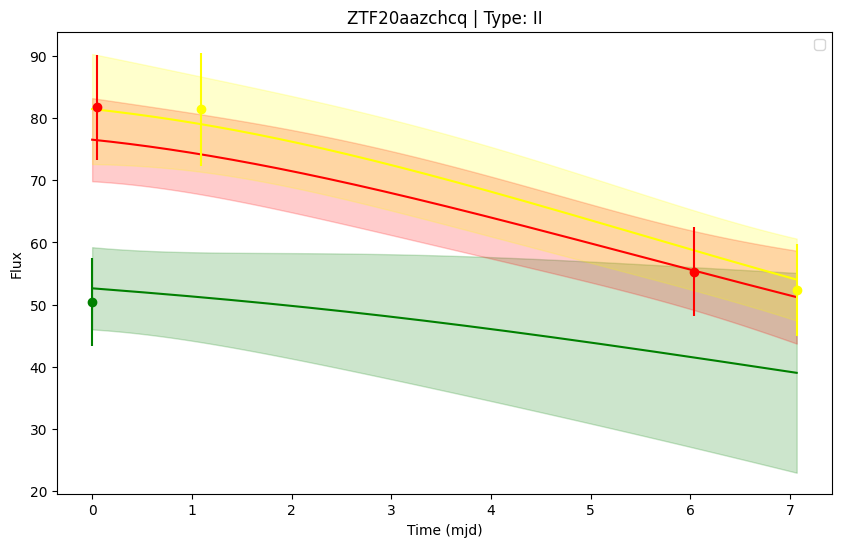

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


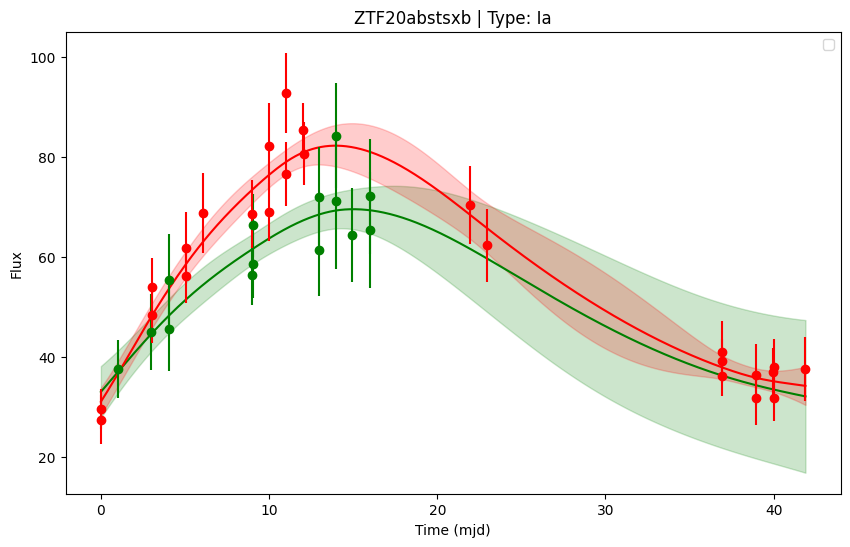

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


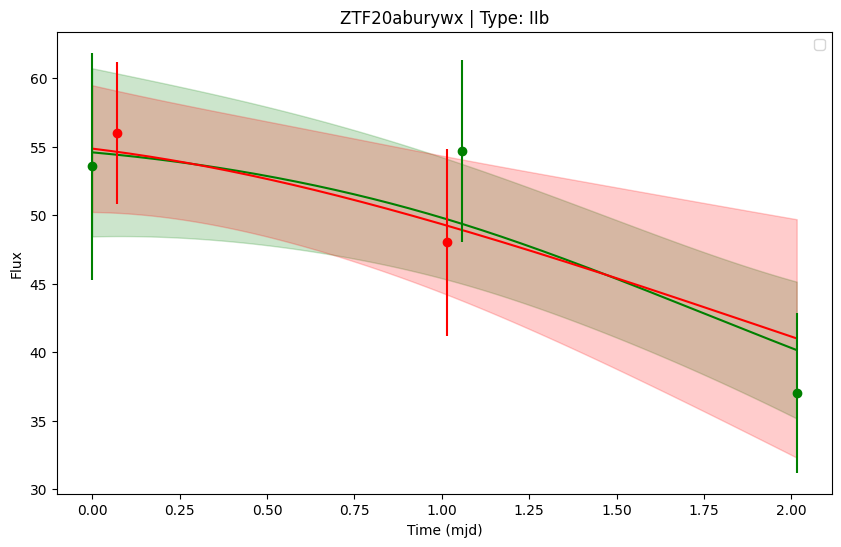

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


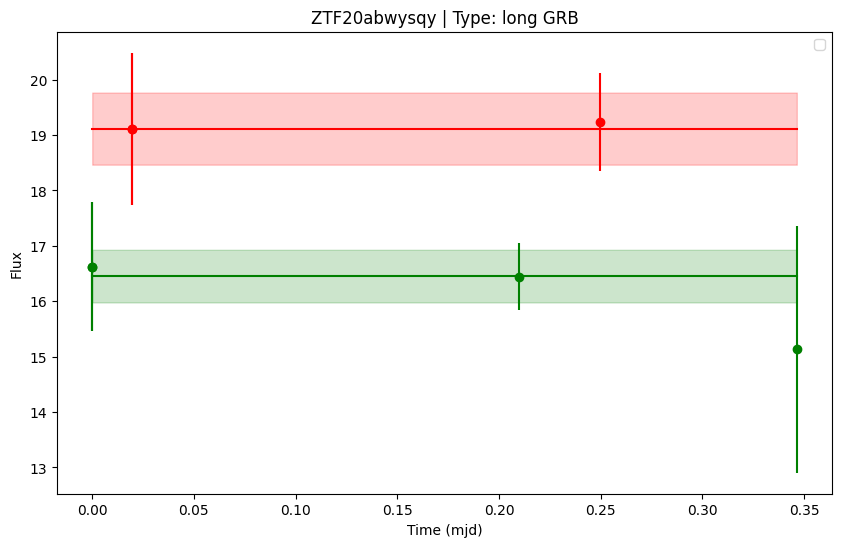

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


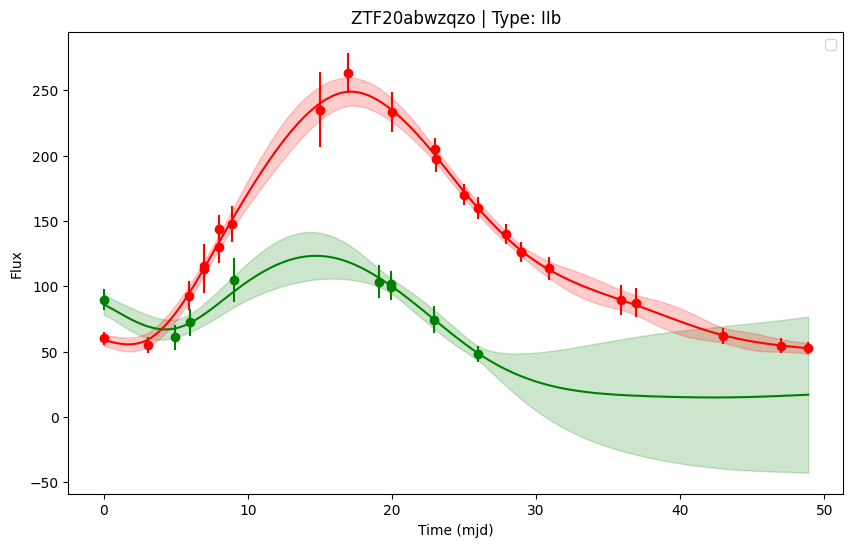

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


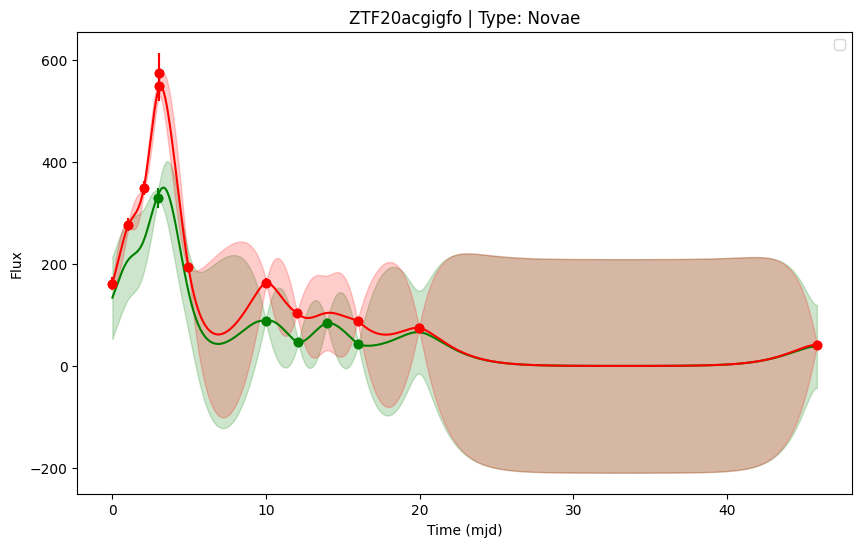

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


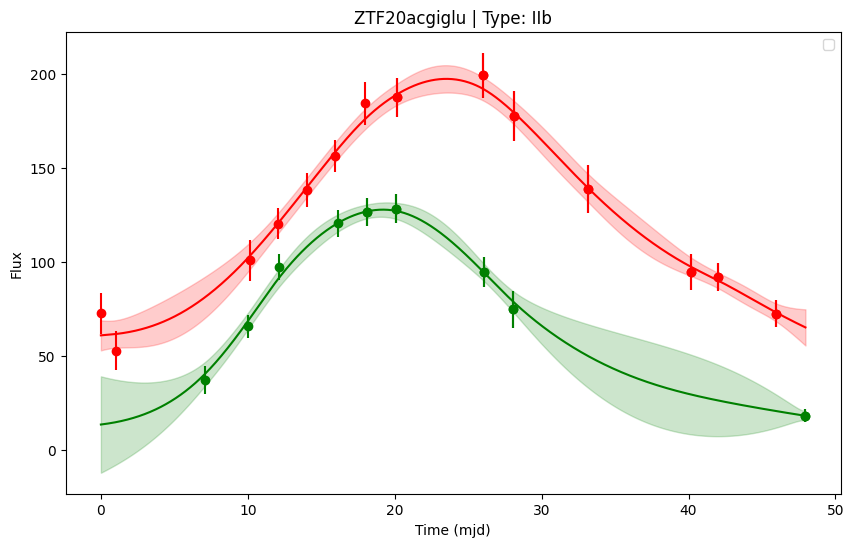

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


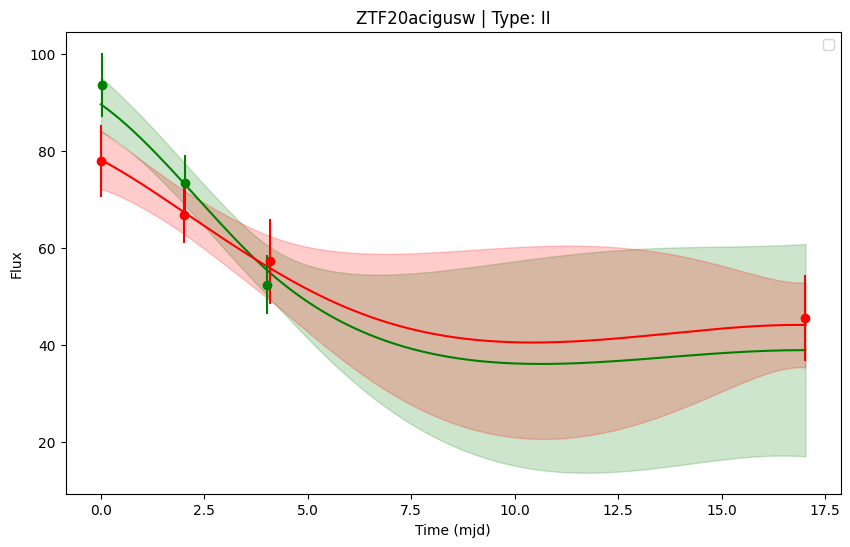

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


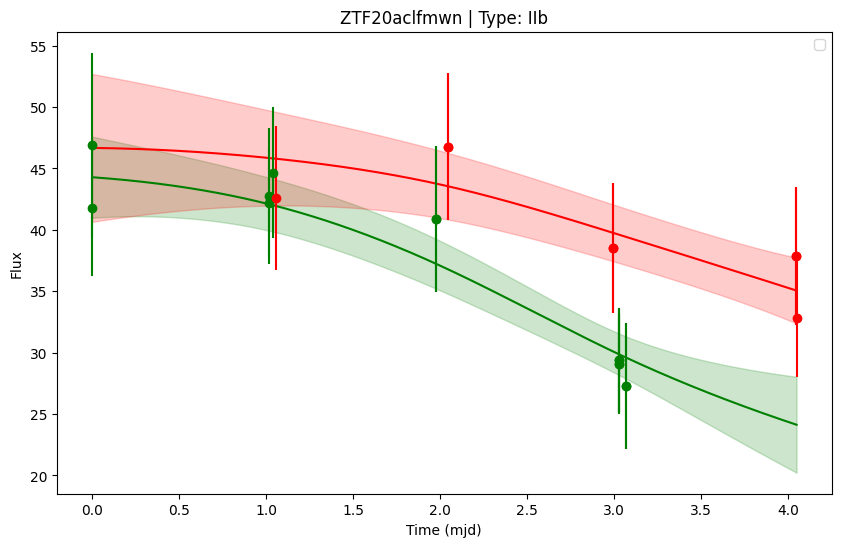

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


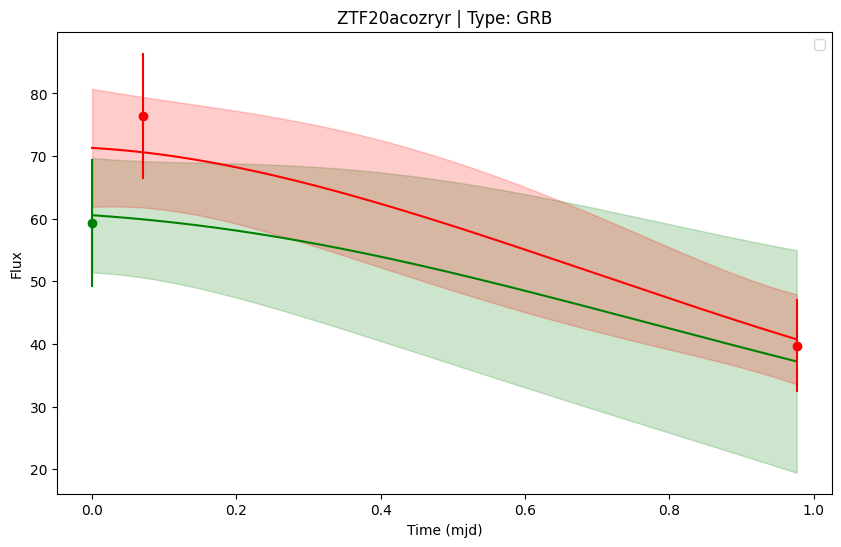

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


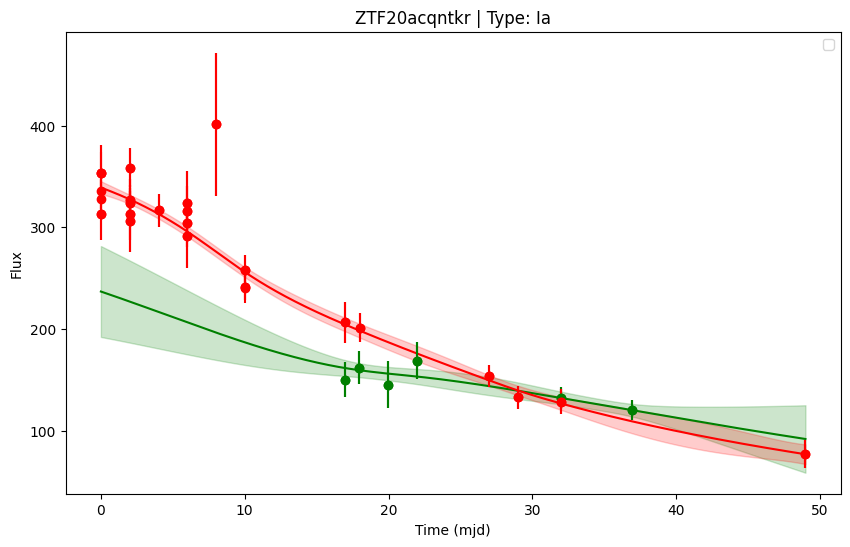

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


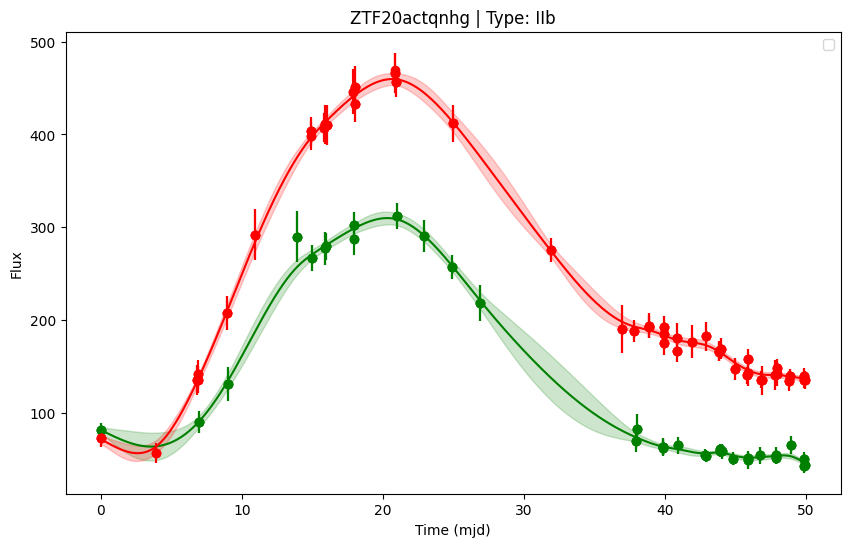

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


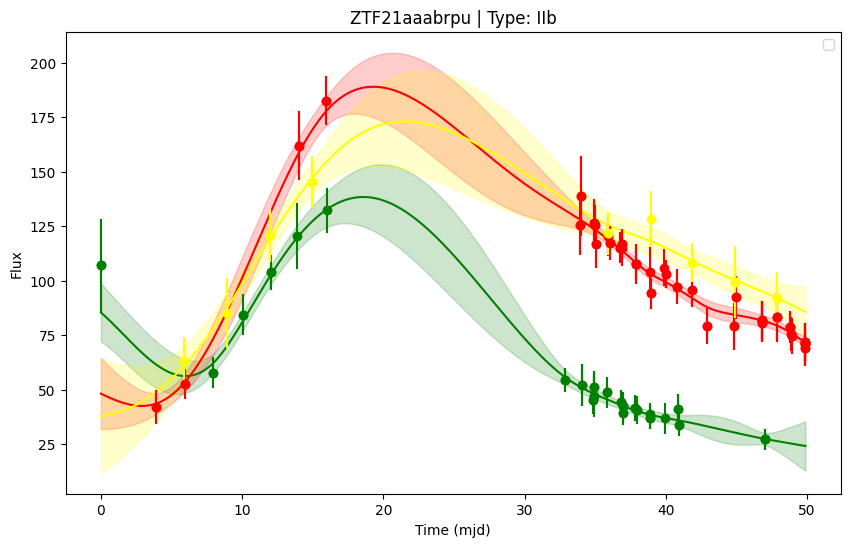

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


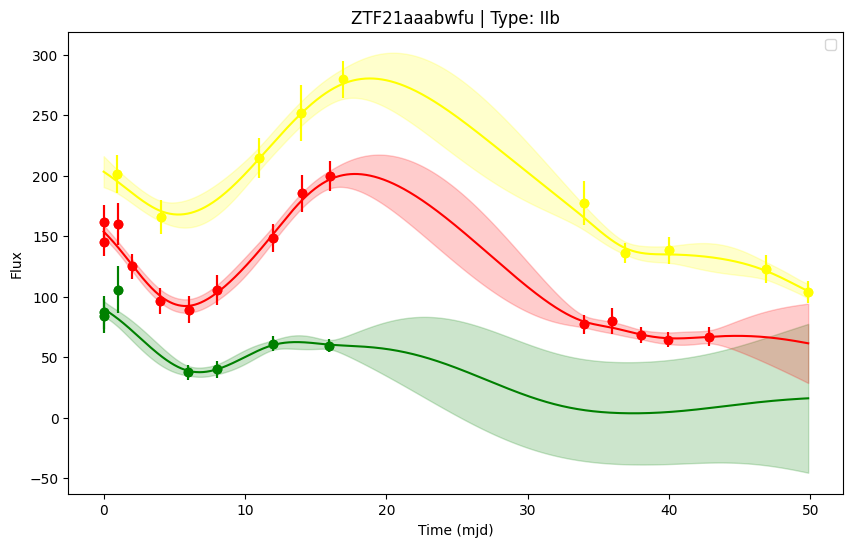

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


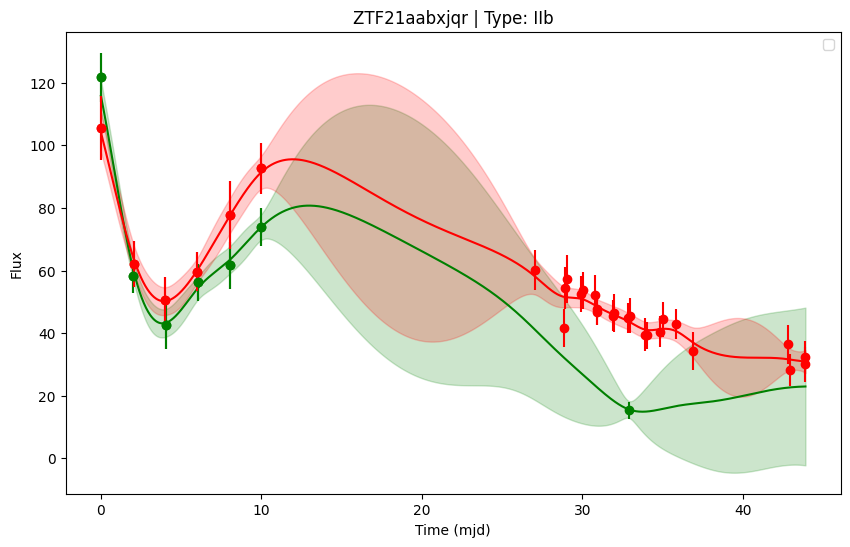

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


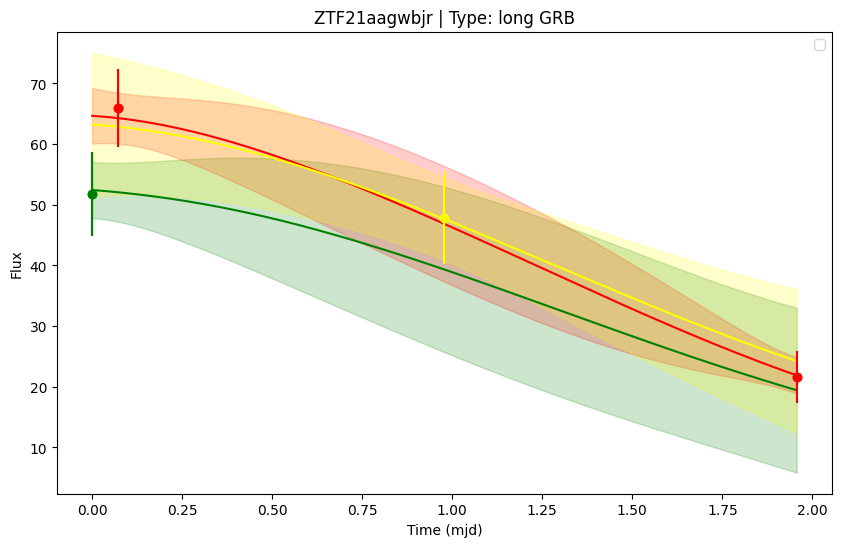

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


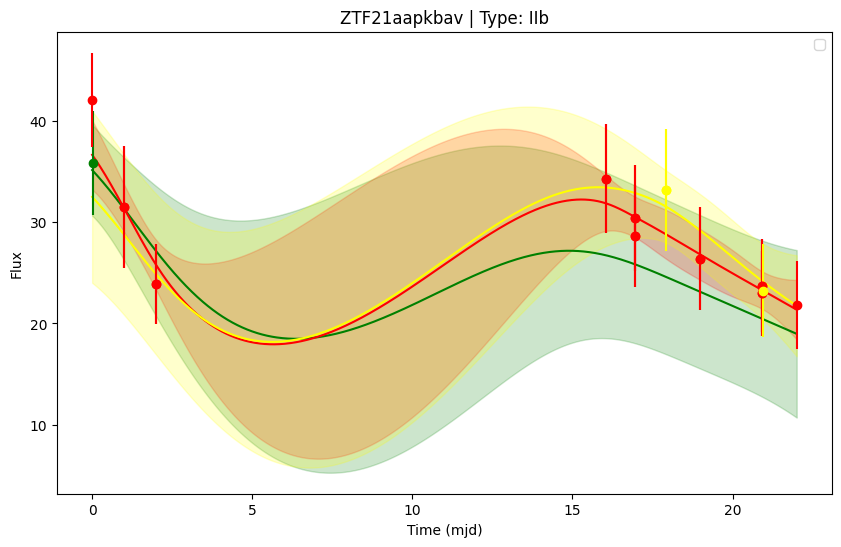

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


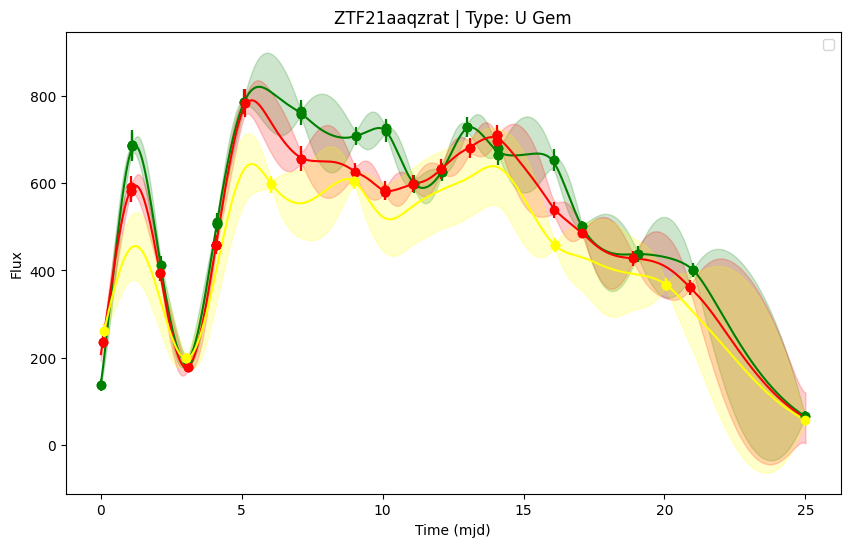

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


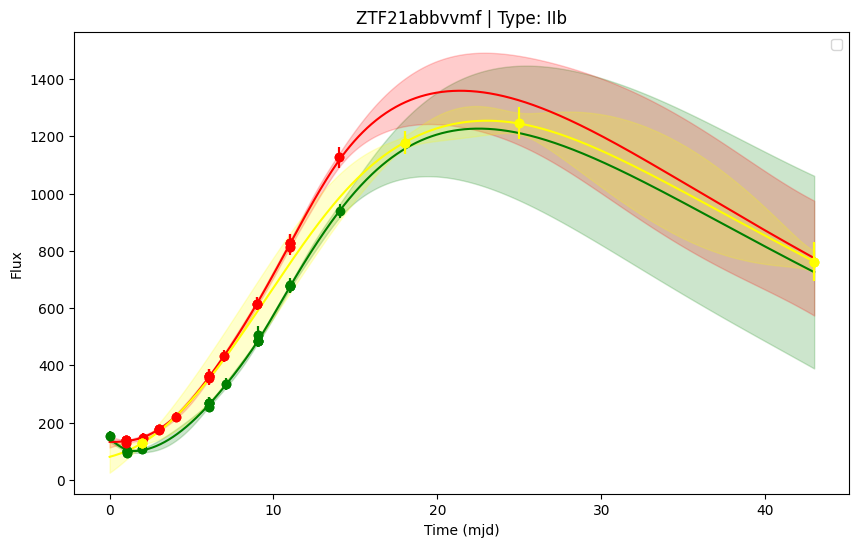

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


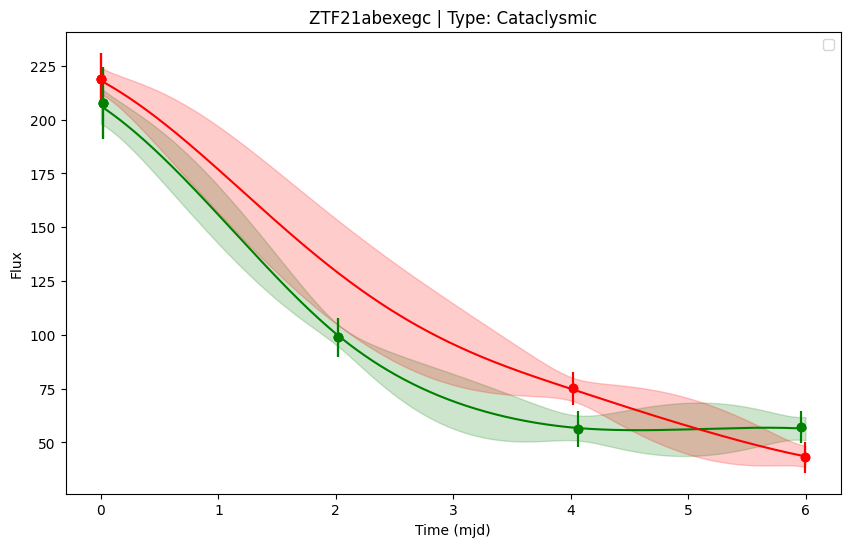

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


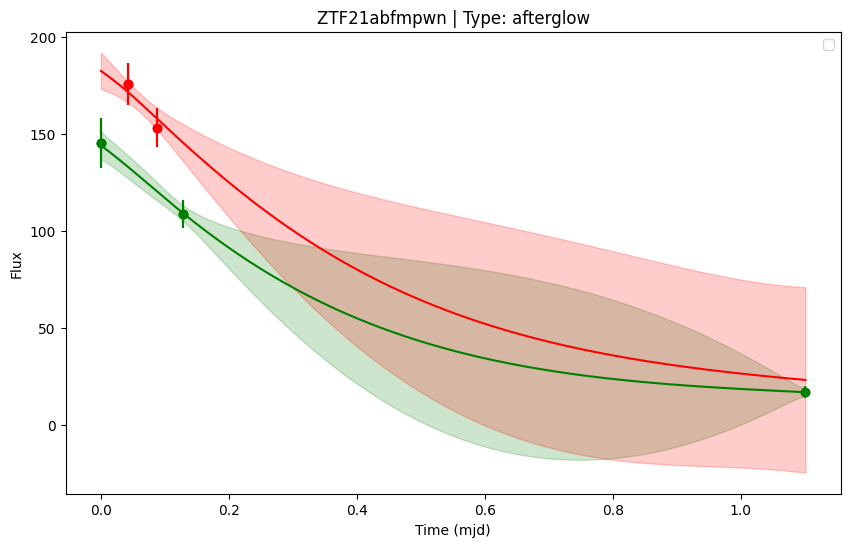

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


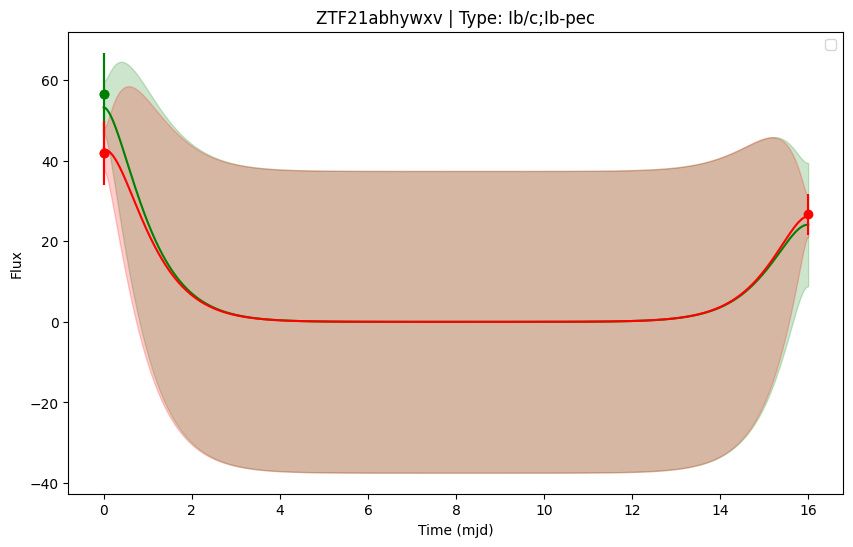

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


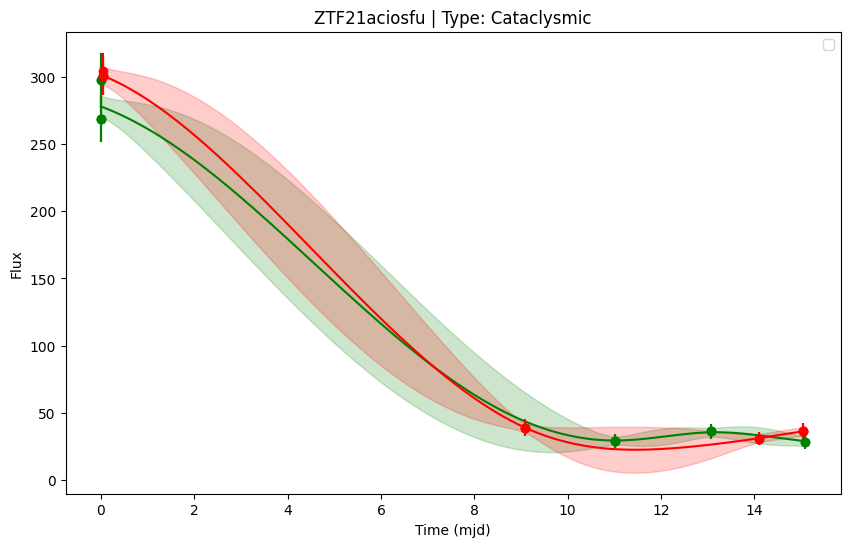

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


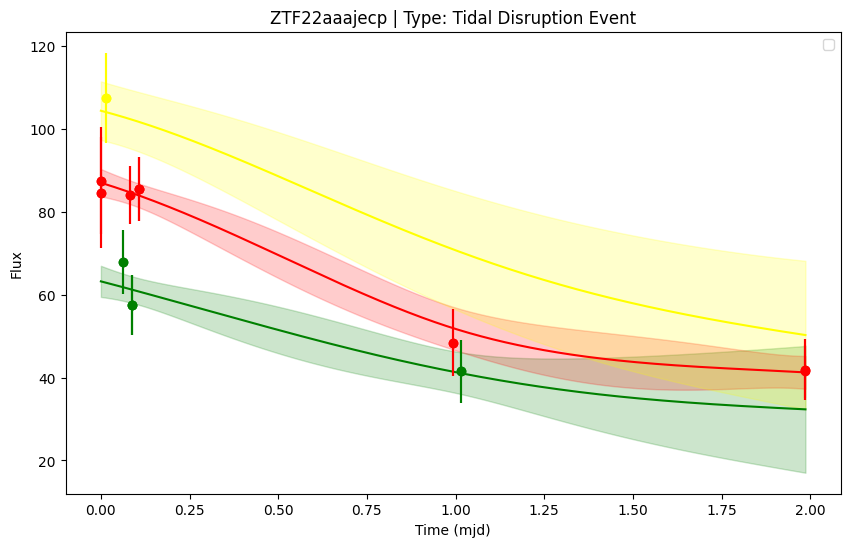

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


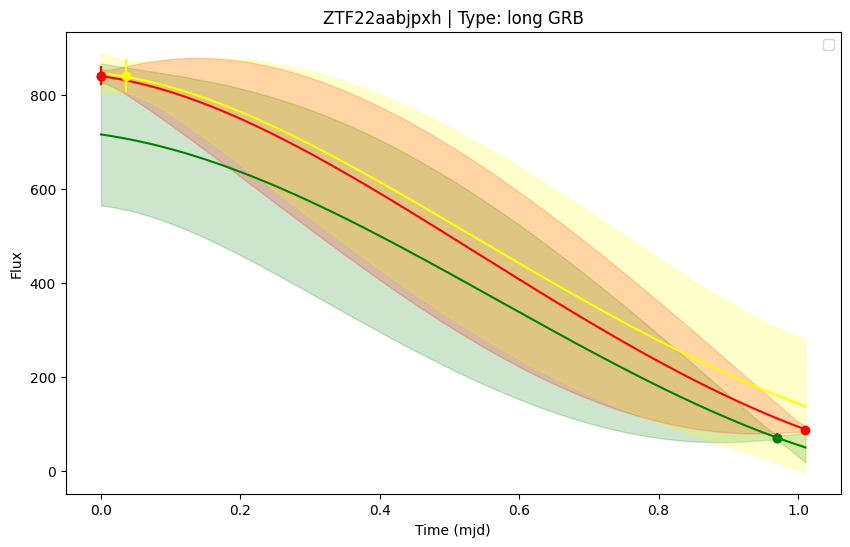

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


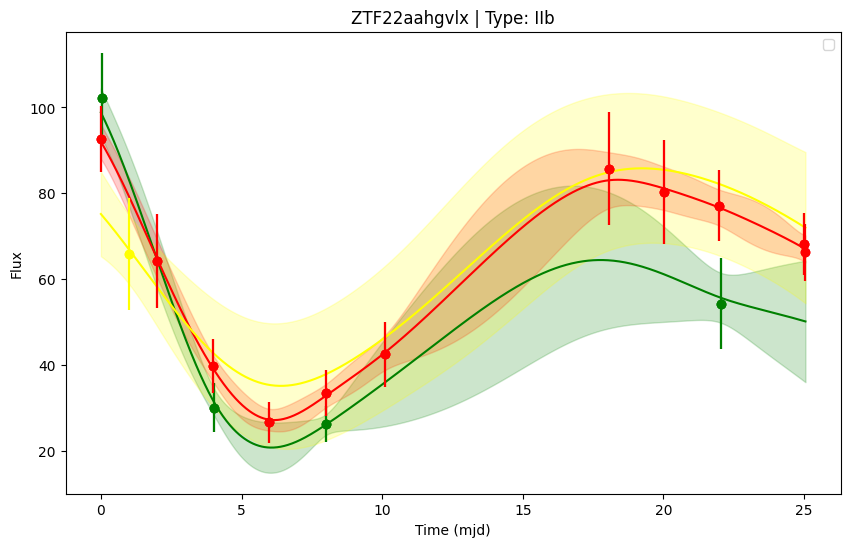

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


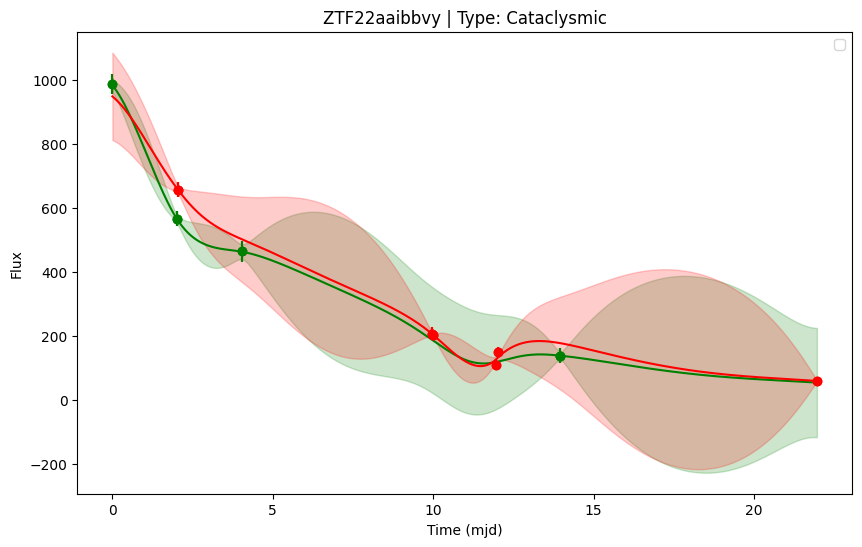

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


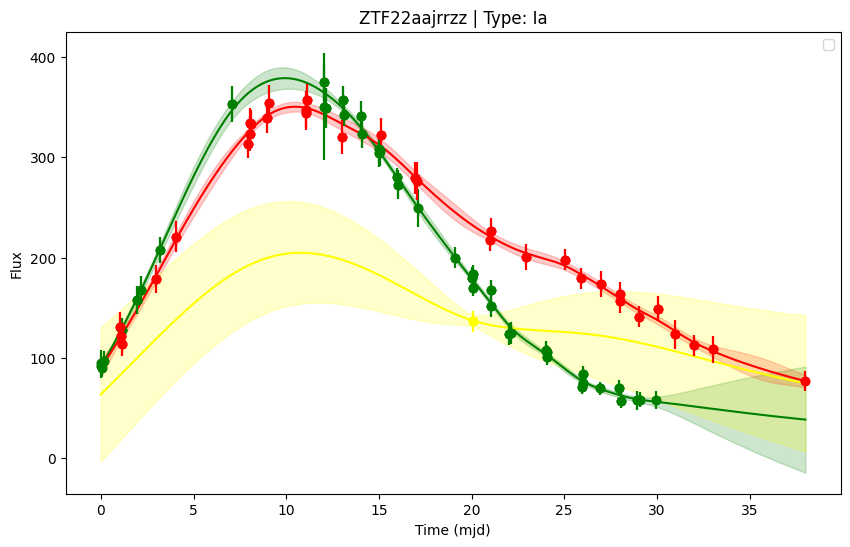

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


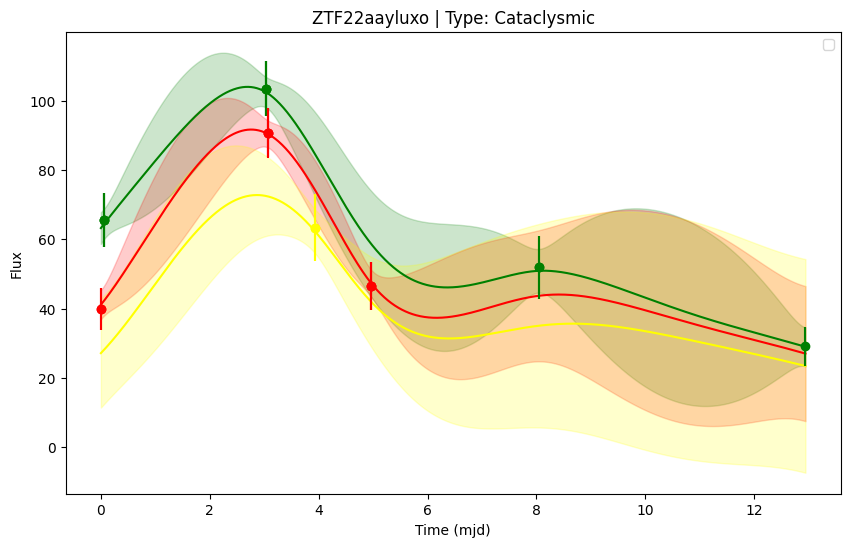

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


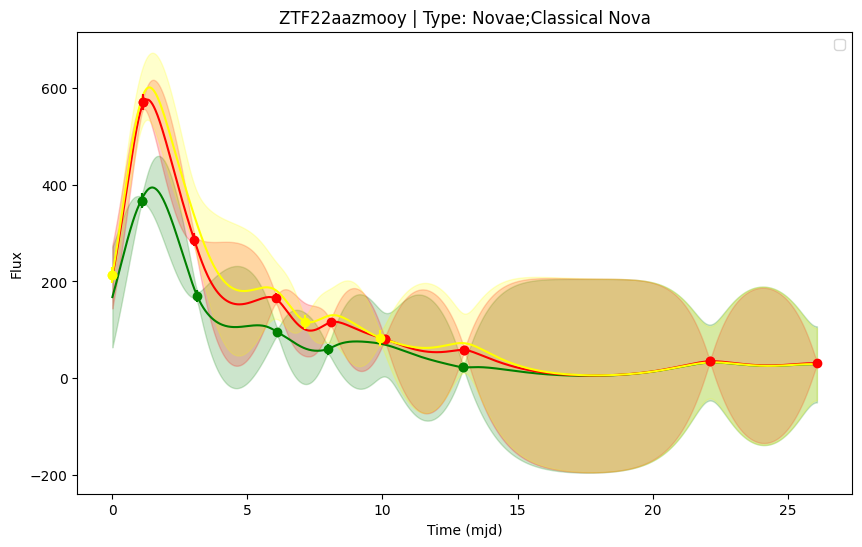

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


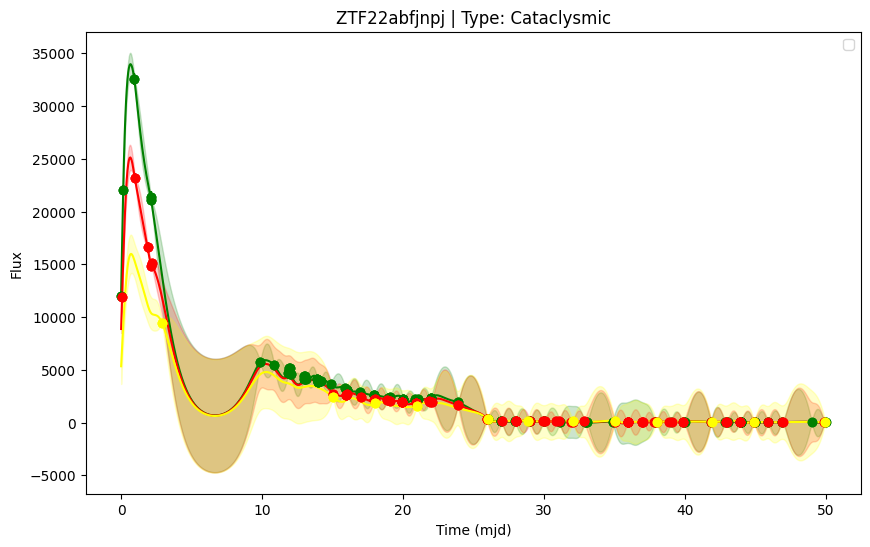

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


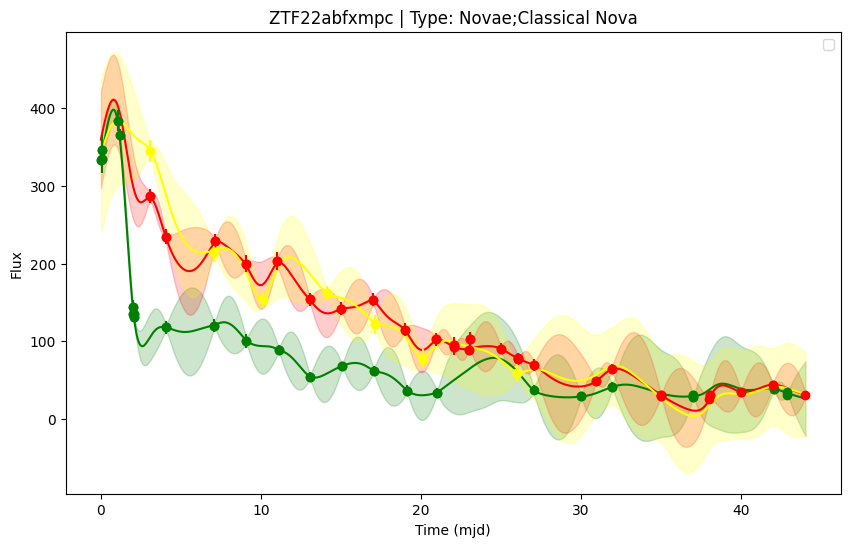

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


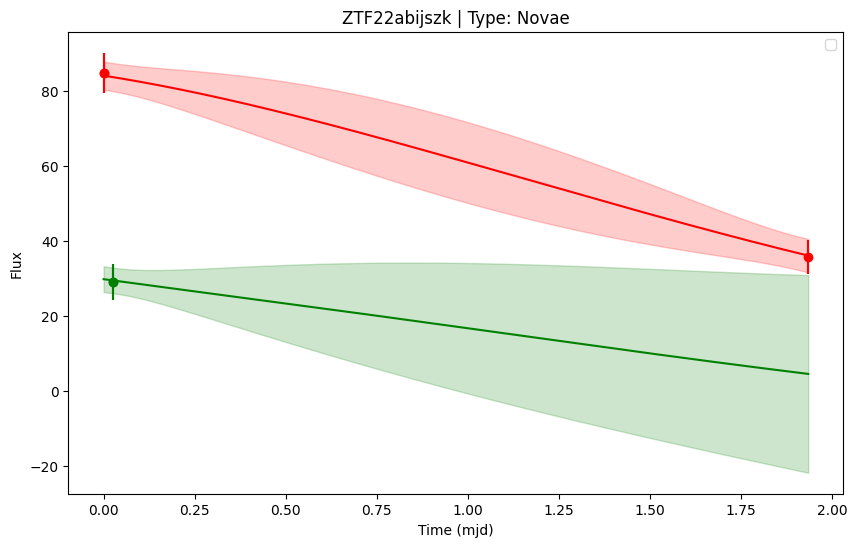

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


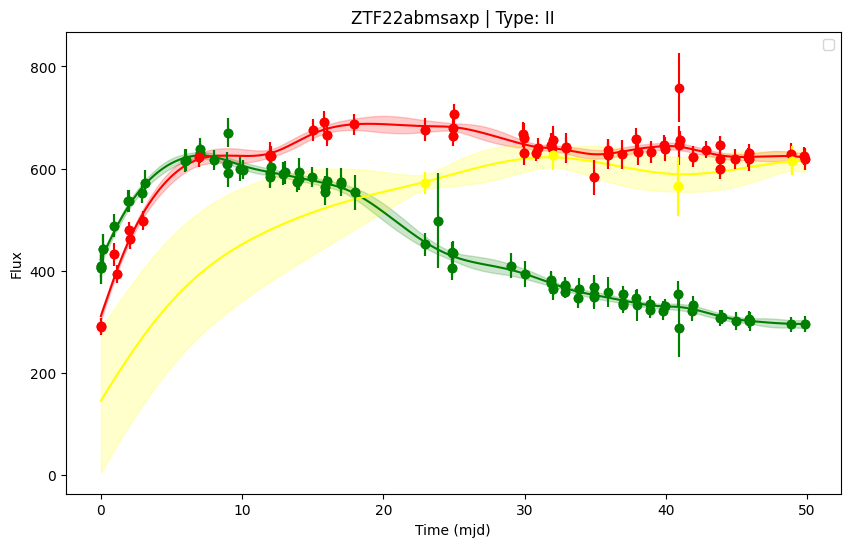

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


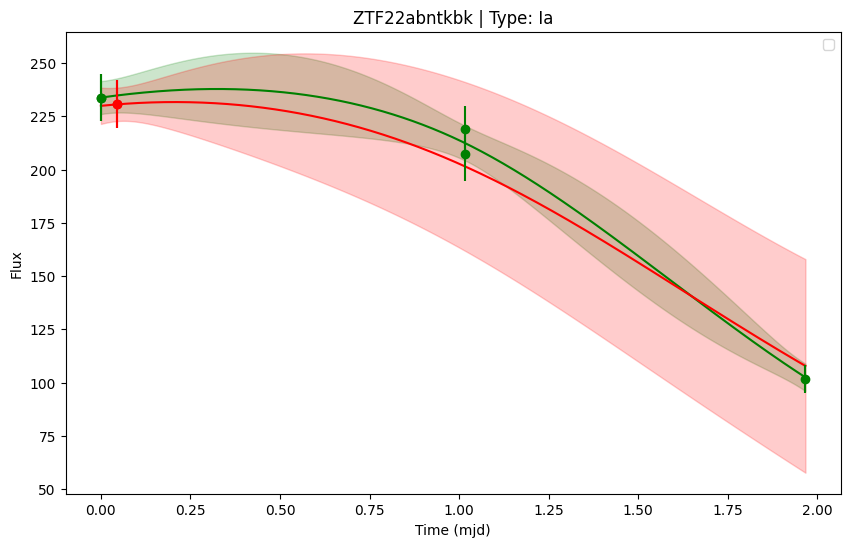

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


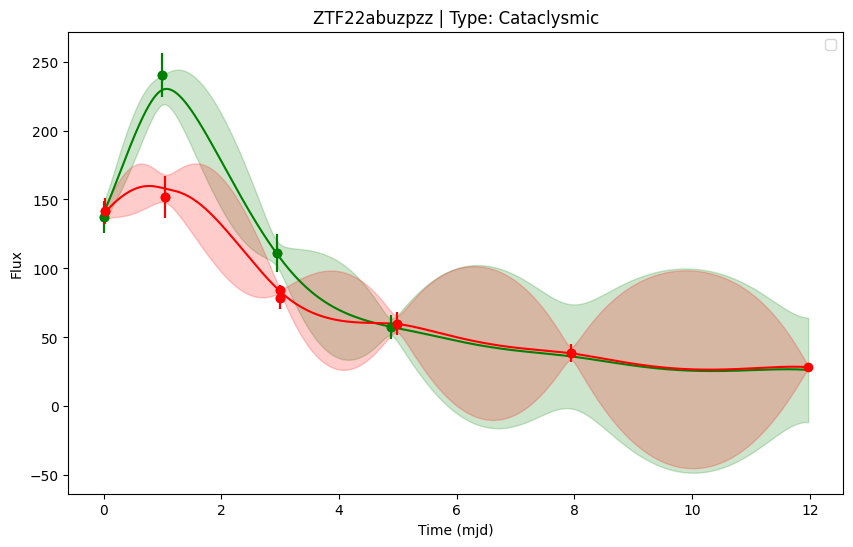

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


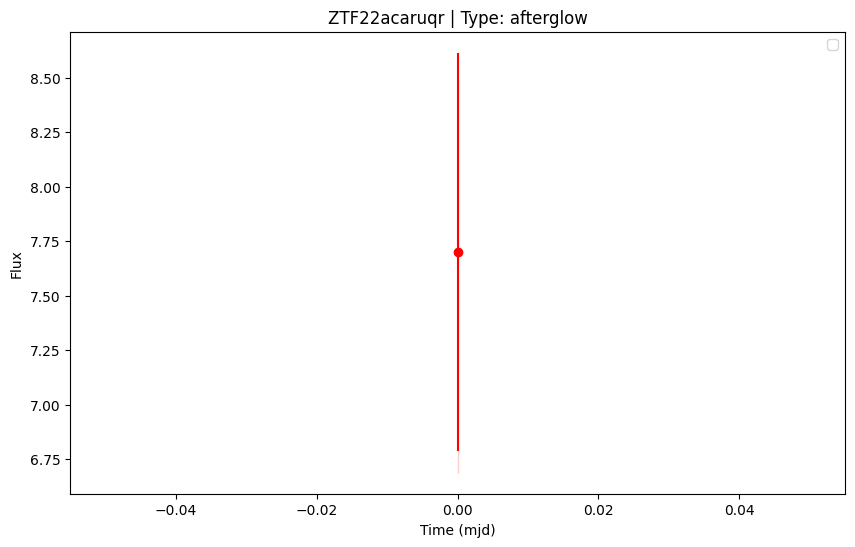

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


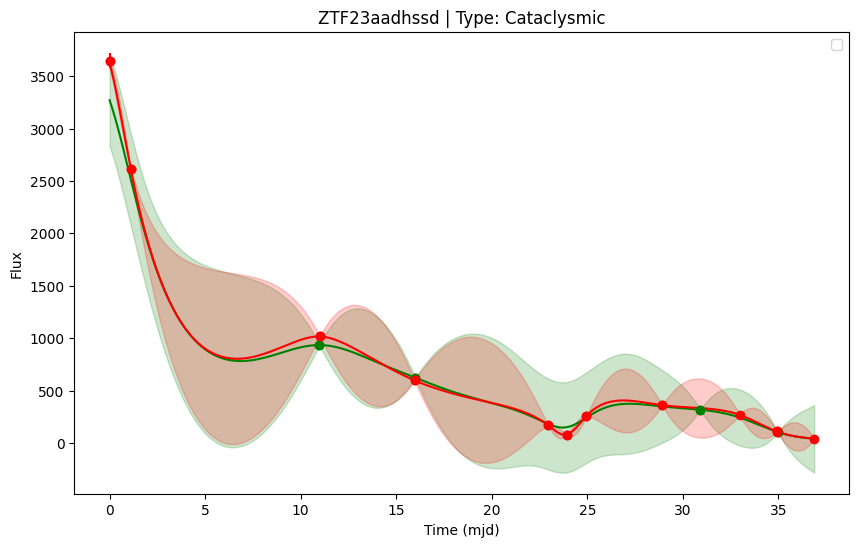

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


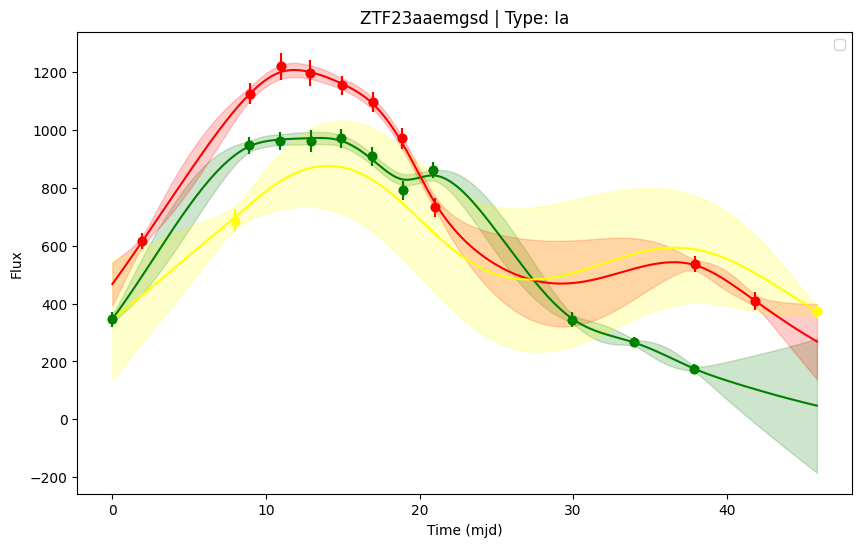

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


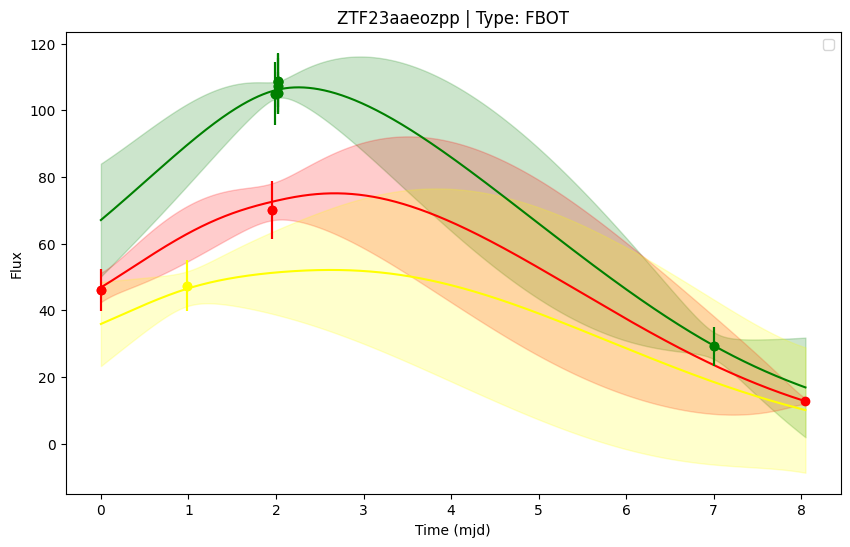

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


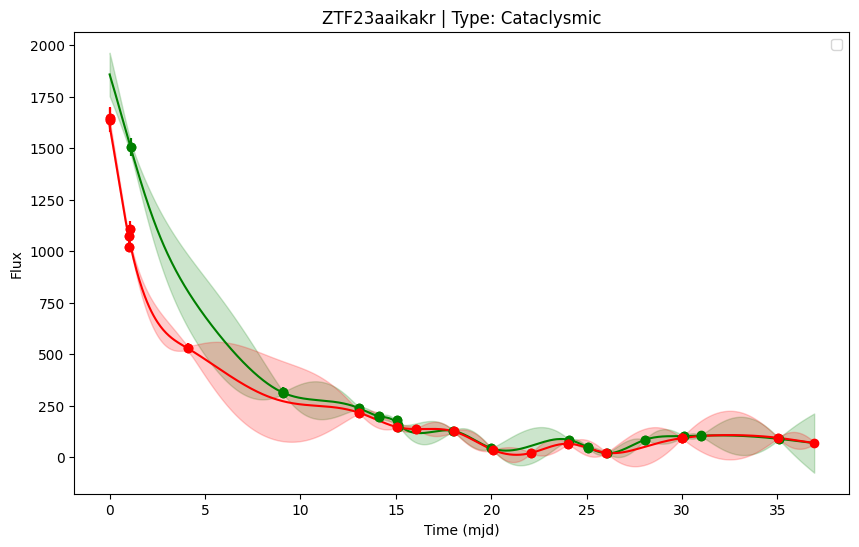

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


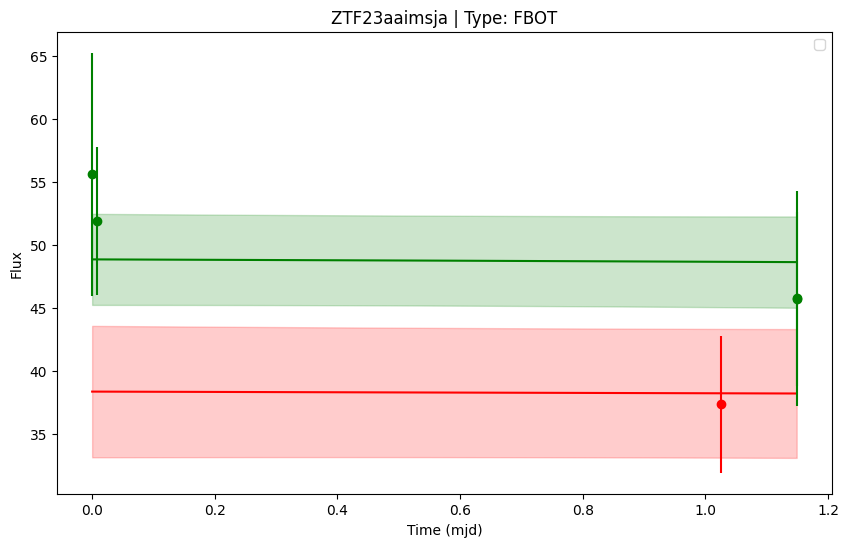

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


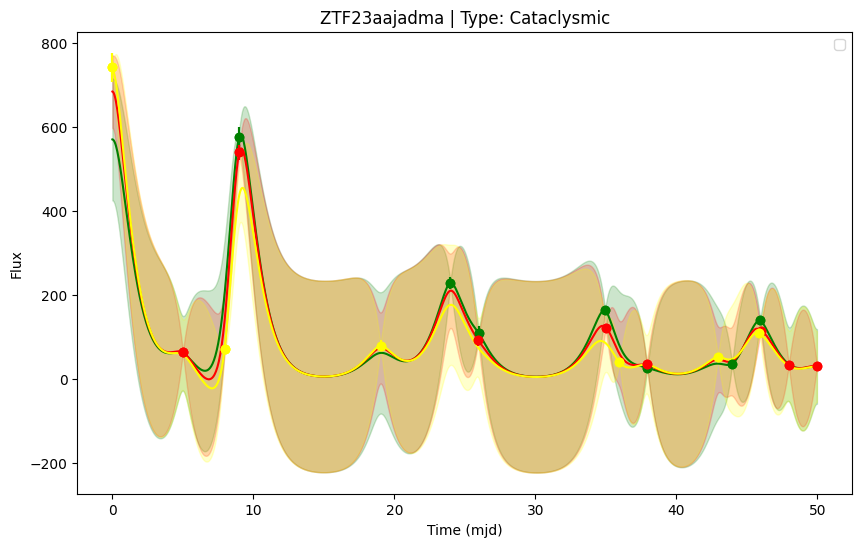

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


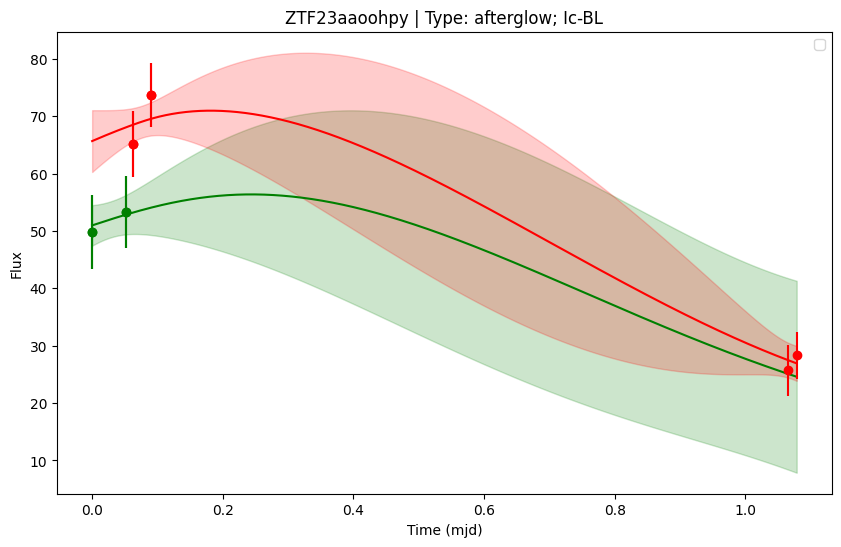

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


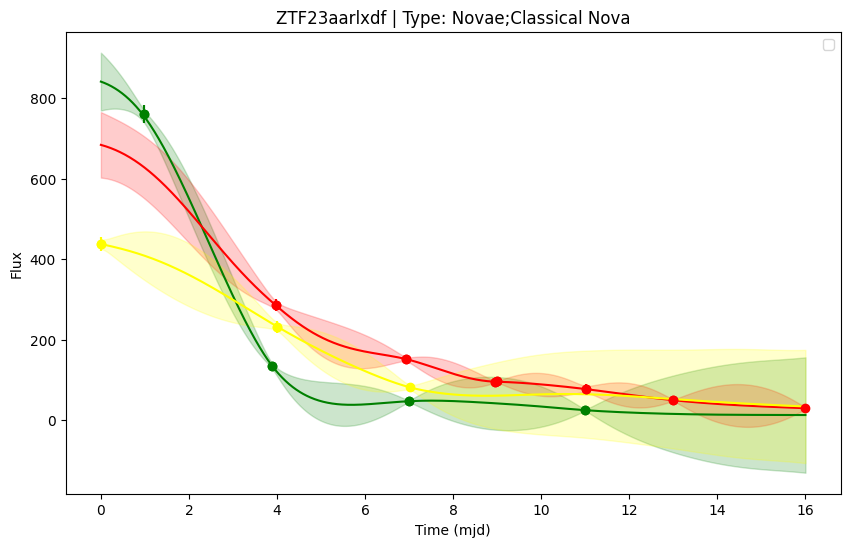

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


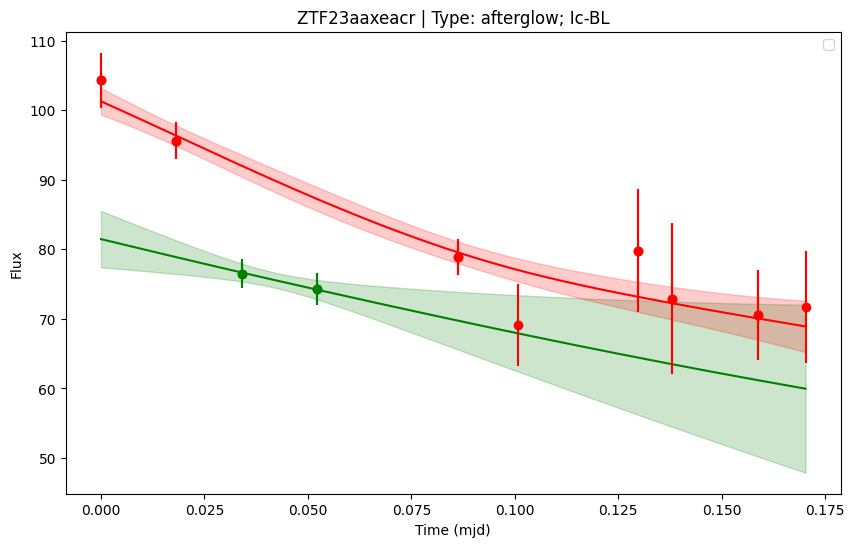

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


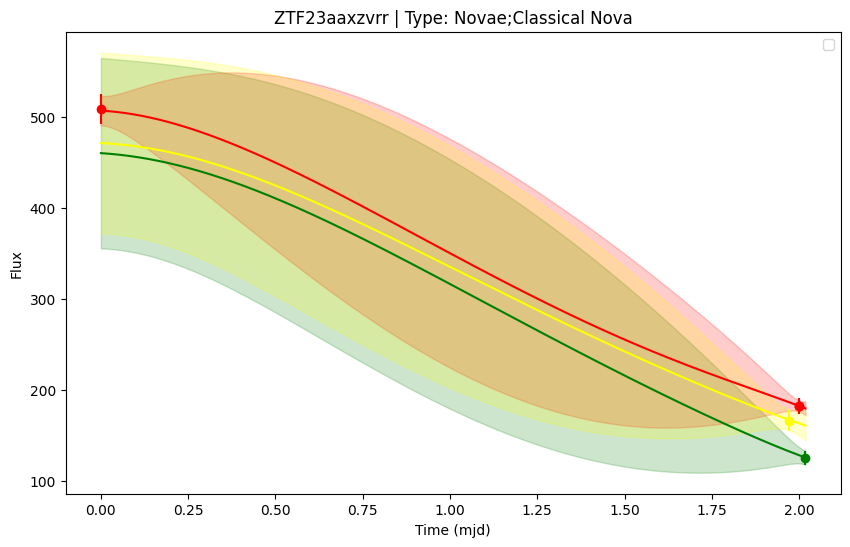

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


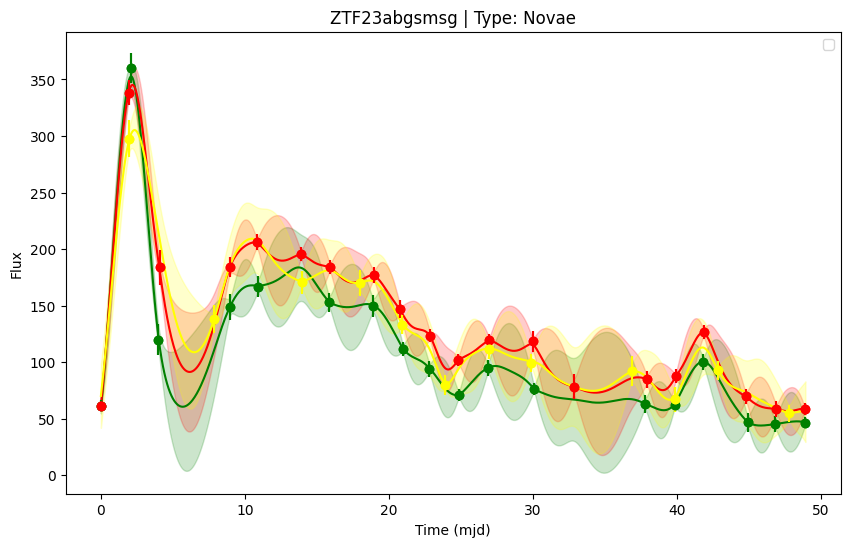

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


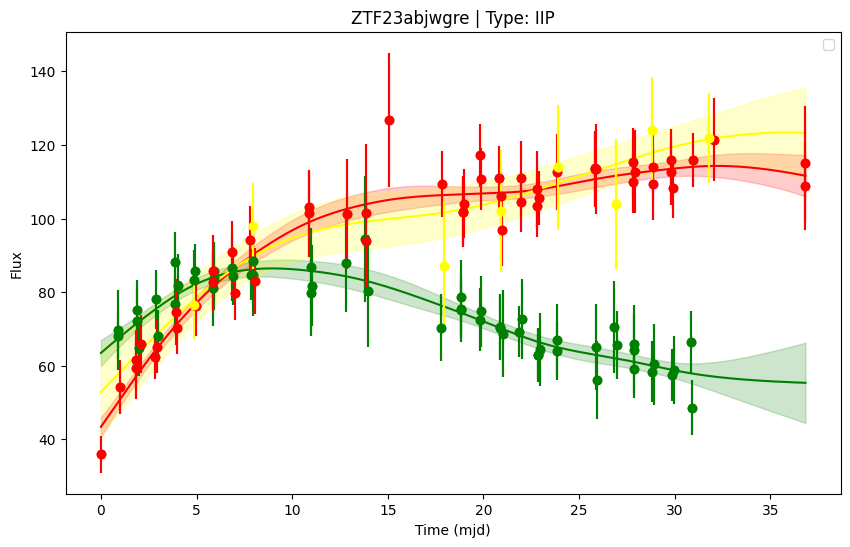

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


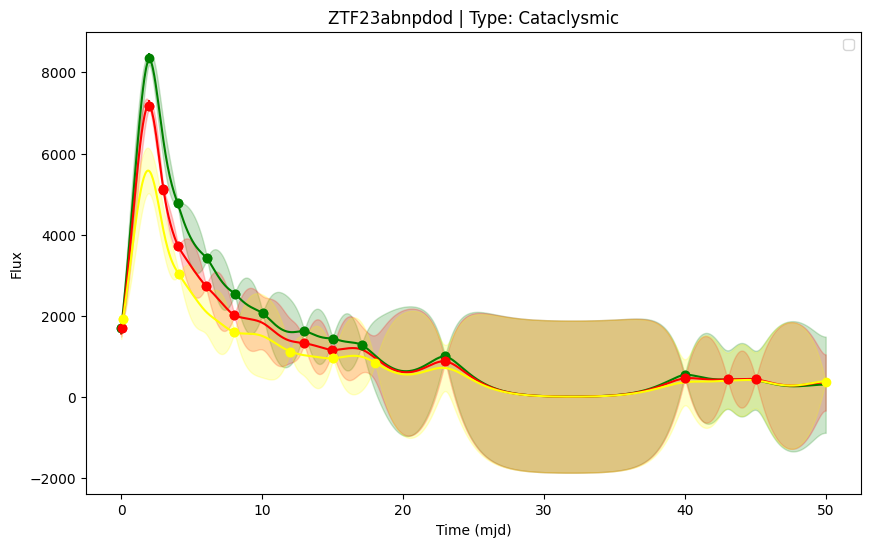

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


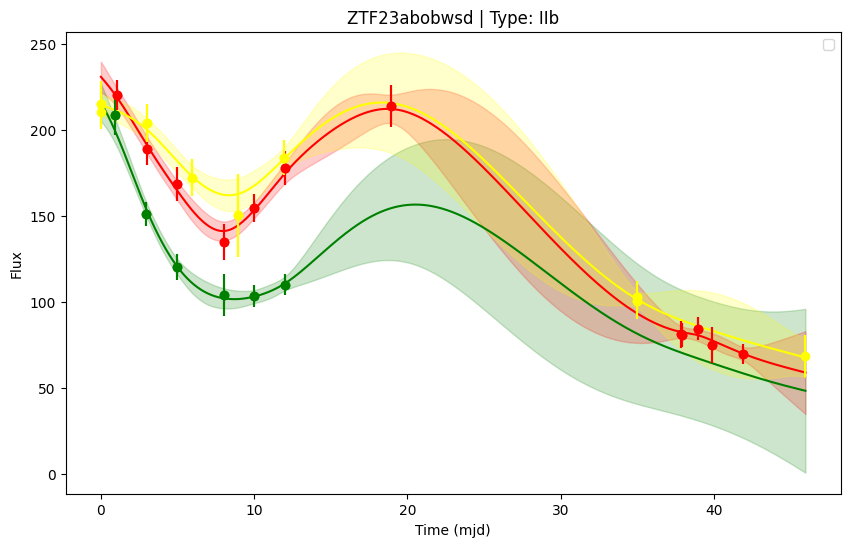

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


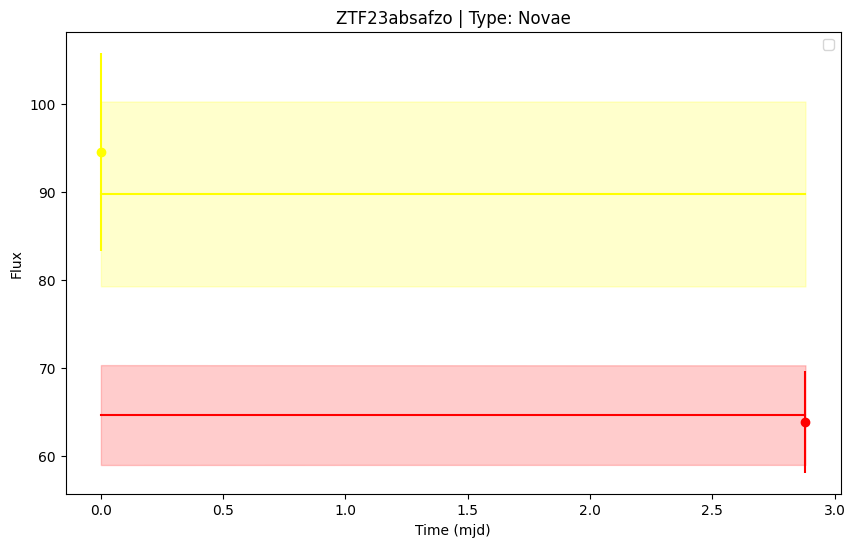

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


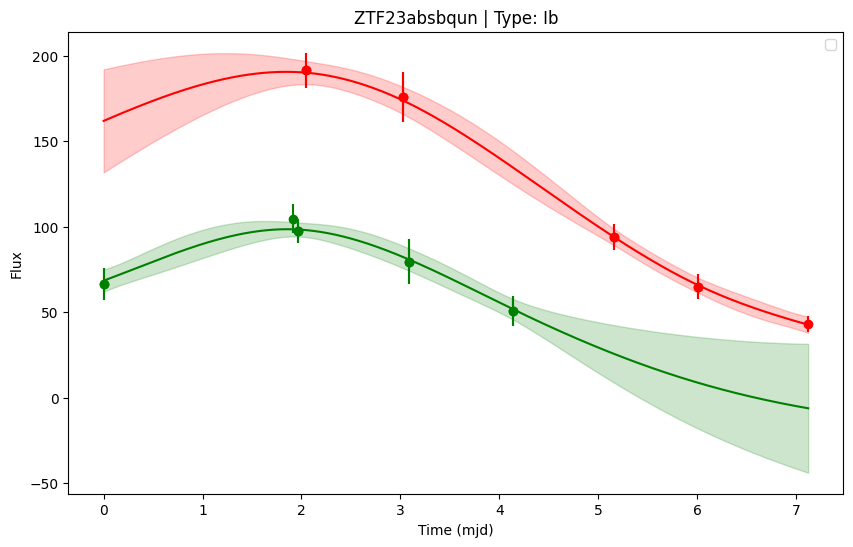

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


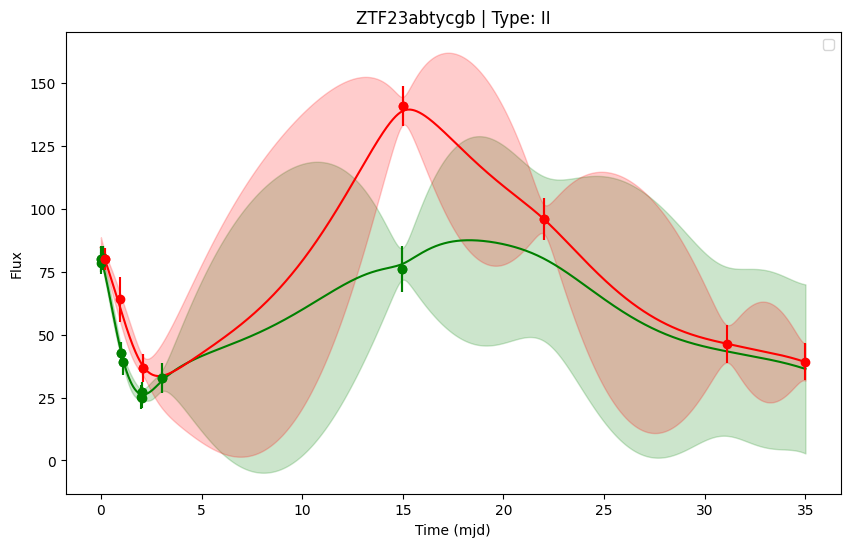

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


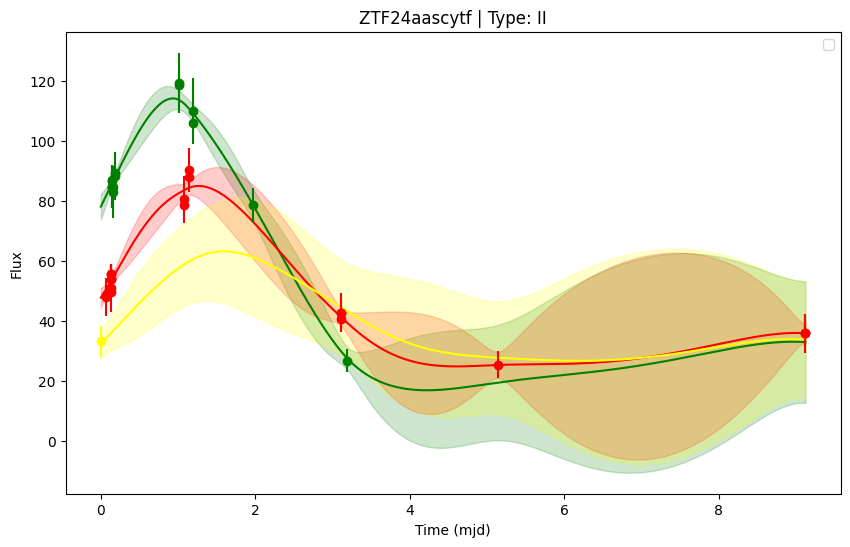

In [33]:
plot_results = total_results
obj_ids = plot_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=True)
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    # plt.savefig(f'figures/gp_plots/{obj}.pdf')
    plt.show()

In [27]:
# question_objects = ['ZTF19abacxod', 'ZTF19abxjrge', 'ZTF21aaabrpu', 'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aapkbav', 'ZTF21aaqzrat', 'ZTF23aajadma', 'ZTF23abtycgb']
# for obj in question_objects:
#     one_df = plot_results[plot_results['obj_id'] == obj]
#     two_df = norm_df[norm_df['obj_id']==obj]
#     two_df = two_df[two_df['mjd']<50]
#     fi, axi = plot_gp(one_df, show_legend=False)
#     for filter_name in ['ztfg', 'ztfr', 'ztfi']:
#         axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
#     plt.show()

In [28]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      0.000000  142.373588   98.668109        30.843697         1.246373   
1      0.049981  145.014457  101.582057        30.013242         1.080243   
2      0.099961  147.656847  104.490322        29.187955         1.080575   
3      0.149942  150.300692  107.379974        28.367979         1.219787   
4      0.199923  152.945927  110.245034        27.553467         1.433721   
...         ...         ...         ...              ...              ...   
71996  9.086873   33.104947   36.051876        20.273348         3.441576   
71997  9.096005   33.093513   36.039692        20.264562         3.332267   
71998  9.105138   33.081261   36.026243        20.258811         3.251571   
71999  9.114270   33.068191   36.011512        20.256105         3.202154   
72000  9.123403   33.054302   35.995481        20.256452         3.185979   

      type        obj_id         mjd_0  redshift  flux_ztfi  flux_error_ztfi  
0      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
1      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
2      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
3      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
4      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
...    ...           ...           ...       ...        ...              ...  
71996   II  ZTF24aascytf  60476.217836    0.0380  33.927364        19.254350  
71997   II  ZTF24aascytf  60476.217836    0.0380  33.912465        19.244562  
71998   II  ZTF24aascytf  60476.217836    0.0380  33.896745        19.238097  
71999   II  ZTF24aascytf  60476.217836    0.0380  33.880203        19.234967  
72000   II  ZTF24aascytf  60476.217836    0.0380  33.862840        19.235181  

[72001 rows x 11 columns]

In [29]:
sorted(total_results['obj_id'].unique())

['ZTF18aakuewf',
 'ZTF18aalrxas',
 'ZTF18abffyqp',
 'ZTF18abvkmgw',
 'ZTF18abwkrbl',
 'ZTF19aanbpus',
 'ZTF19aapfmki',
 'ZTF19aatesgp',
 'ZTF19abacxod',
 'ZTF19abxjrge',
 'ZTF19abxtcio',
 'ZTF19abyjzvd',
 'ZTF19acbumks',
 'ZTF19accjfgv',
 'ZTF20aahfqpm',
 'ZTF20aajnksq',
 'ZTF20aaxhzhc',
 'ZTF20aayrobw',
 'ZTF20aazchcq',
 'ZTF20abstsxb',
 'ZTF20aburywx',
 'ZTF20abwysqy',
 'ZTF20abwzqzo',
 'ZTF20acgigfo',
 'ZTF20acgiglu',
 'ZTF20acigusw',
 'ZTF20aclfmwn',
 'ZTF20acozryr',
 'ZTF20acqntkr',
 'ZTF20actqnhg',
 'ZTF21aaabrpu',
 'ZTF21aaabwfu',
 'ZTF21aabxjqr',
 'ZTF21aagwbjr',
 'ZTF21aapkbav',
 'ZTF21aaqzrat',
 'ZTF21abbvvmf',
 'ZTF21abexegc',
 'ZTF21abfmpwn',
 'ZTF21abhywxv',
 'ZTF21aciosfu',
 'ZTF22aaajecp',
 'ZTF22aabjpxh',
 'ZTF22aahgvlx',
 'ZTF22aaibbvy',
 'ZTF22aajrrzz',
 'ZTF22aayluxo',
 'ZTF22aazmooy',
 'ZTF22abfjnpj',
 'ZTF22abfxmpc',
 'ZTF22abijszk',
 'ZTF22abmsaxp',
 'ZTF22abntkbk',
 'ZTF22abuzpzz',
 'ZTF22acaruqr',
 'ZTF23aadhssd',
 'ZTF23aaemgsd',
 'ZTF23aaeozpp',
 'ZTF23aaikakr

In [30]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    #print(type(z))
    try:
        z = float(z)
    except:
        if type(z) == str:
            z = float(z.split('±')[0])
            #print('converted')
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        #print(z)
        #print(type(z))
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

def Norm2Mag(df):
    df_copy = df.copy()
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        df_copy[f'mag_{filter}'] = 23.9 - 2.5 * np.log10(df_copy[f'flux_{filter}'])
        df_copy[f'abs_mag_{filter}'] = [absmag(m, z) for m, z in zip(df_copy[f'mag_{filter}'], df_copy['redshift'])]
        df_copy[f'mag_error_{filter}'] = 2.5 * df_copy[f'flux_error_{filter}'] / (df_copy[f'flux_{filter}'] * np.log(10))
    df_copy['t'] = df_copy['mjd']
    df_copy['mjd'] = df_copy['mjd'] + df_copy['mjd_0']
    # df_copy.reset_index(drop=True, inplace=True)
    return df_copy  

In [31]:
# total_mag = Norm2Mag(total_results)
# # total_mag[total_mag['obj_id'] == 'ZTF18aakuewf']
# display(total_mag)
# # total_mag[total_mag['mag_error_ztfg'] < 0]
# total_mag['mag_error_ztfg']

In [32]:
# total_mag.to_csv('gp_objects.csv', index=False)